# Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

### Select plate model

To use the plate model from the published paper (Alfonso et al., 2024), set `use_provided_plate_model` to `True`. Otherwise, leave `use_provided_plate_model` as `False` and set `plate_model_name` to a valid model name for the [`plate-model-manager`](https://github.com/michaelchin/plate-model-manager/blob/4f66423b53950bf42f5dac1228e61fd1e19fdf6e/models.json) package, or set `plate_model_name` to `None` and place GPlates files in a directory named `plate_model`.

| `use_provided_plate_model` | `plate_model_name` | result |
| - | - | - |
| `True` | Any | Use Alfonso et al., 2024 model |
| `False` | Model name string (e.g. `"muller2022"`) | Use specified plate model |
| `False` | `None` | Use files in `plate_model` directory |

In [1]:
use_provided_plate_model = True
plate_model_name = "muller2022"

### Set other parameters

In [2]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Number of processes to use
n_jobs = 4

# Overwrite any existing output files
overwrite = True

# Timespan for analysis
min_time = 0
max_time = 170

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [3]:
from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

output_dir = "outputs"

If any of the following exist as environment variables, they will replace the values defined above:

In [4]:
import os

n_jobs = int(os.environ.get("N_JOBS", n_jobs))
overwrite = bool(int(os.environ.get("OVERWRITE", overwrite)))
min_time = int(os.environ.get("MIN_TIME", min_time))
max_time = int(os.environ.get("MAX_TIME", max_time))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))
output_dir = os.environ.get("OUTPUT_DIR", output_dir)

times = range(min_time, max_time + 1)

## Notebook setup

Imports, definitions, etc.

### Imports

In [5]:
import glob
import tempfile

import cartopy.crs as ccrs
import pandas as pd
import pygplates
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
)
from lib.misc import (
    filter_topological_features,
    reconstruct_by_topologies,
)
from lib.plate_models import (
    get_plate_reconstruction,
    get_plot_topologies,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()

env: PYTHONWARNINGS=ignore::UserWarning


### Input and output files

If necessary, the plate model will be downloaded:

In [6]:
plate_model_dir = "plate_model"
if use_provided_plate_model:
    check_plate_model(plate_model_dir, verbose=True)
    plate_model_name = None
plate_model, _tf = get_plate_reconstruction(
    model_name=plate_model_name,
    model_dir=plate_model_dir,
    filter_topologies=True,
)

if use_provided_plate_model:
    coastlines_filenames = [os.path.join(
        plate_model_dir,
        "StaticGeometries",
        "AgeGridInput",
        "CombinedTerranes.gpml",
    )]
    gplot = PlotTopologies(
        plate_model,
        coastlines=coastlines_filenames,
    )
else:
    gplot = get_plot_topologies(
        model_name=plate_model_name,
        model_dir=plate_model_dir,
        plate_reconstruction=plate_model,
        filter_topologies=True,
    )

output_dir = os.path.join(output_dir, "global")

### Plot options

These should generally be left unchanged.

In [7]:
lon_0 = 0.0
projection = ccrs.Mollweide(lon_0)

imshow_kwargs = dict(
    vmin=0,
    vmax=60,
    cmap="viridis"
)

### Load training data

The training dataset is used to plot deposit locations on the maps.

In [8]:
training_filename = os.path.join(data_dir, "training_data_global.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]

### Reconstruct deposit data for plots

In [9]:
positives = reconstruct_by_topologies(
    data=(positives[["lon", "lat", "age (Ma)", "label"]]).copy(),
    plate_reconstruction=plate_model,
    times=times,
)

## Example plot

Create an example plot at a single time step (by default, 110 Ma).

PU example plot:


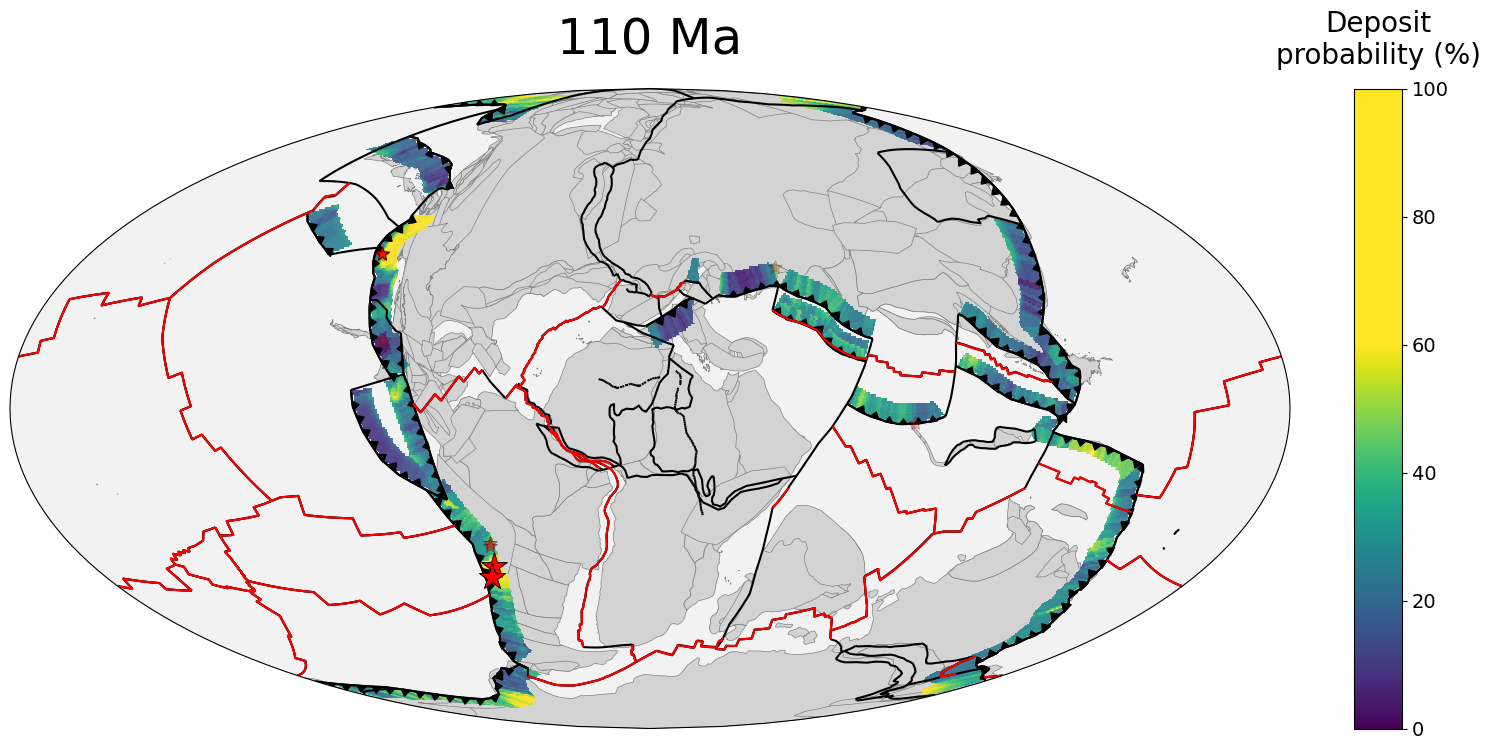

In [10]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 110  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=lon_0,
        imshow_kwargs=imshow_kwargs,
    )

## Create all plots

This will create the plots for all models.

In [11]:
for algorithm in ("PU", "SVM"):
    output_filename = os.path.join(
        output_dir,
        algorithm,
        "probability_animation.mp4",
    )
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    # Create all plots
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(n_jobs=n_jobs, verbose=int(verbose)) as parallel:

        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives,
                output_filename=o,
                central_meridian=lon_0,
                imshow_kwargs=imshow_kwargs,
            )
            for t, o in zip(times, output_filenames)
        )
        create_animation(
            image_filenames=output_filenames[::-1],  # reverse order of frames (forward in time)
            output_filename=output_filename,
            fps=10,  # framerate of output video
            bitrate="5000k",
        )

Moviepy - Building video outputs/global/PU/probability_animation.mp4.
Moviepy - Writing video outputs/global/PU/probability_animation.mp4



t:   0%|                                                                                                      | 0/513 [00:00<?, ?it/s, now=None]

t:   0%|▎                                                                                             | 2/513 [00:00<00:41, 12.45it/s, now=None]

t:   1%|▋                                                                                             | 4/513 [00:00<00:50, 10.05it/s, now=None]

t:   1%|█                                                                                             | 6/513 [00:00<01:11,  7.13it/s, now=None]

t:   1%|█▎                                                                                            | 7/513 [00:00<01:06,  7.57it/s, now=None]

t:   2%|█▍                                                                                            | 8/513 [00:01<01:21,  6.17it/s, now=None]

t:   2%|█▋                                                                                            | 9/513 [00:01<01:14,  6.79it/s, now=None]

t:   2%|█▊                                                                                           | 10/513 [00:01<01:08,  7.34it/s, now=None]

t:   2%|█▉                                                                                           | 11/513 [00:01<01:24,  5.92it/s, now=None]

t:   2%|██▏                                                                                          | 12/513 [00:01<01:16,  6.58it/s, now=None]

t:   3%|██▎                                                                                          | 13/513 [00:01<01:09,  7.20it/s, now=None]

t:   3%|██▌                                                                                          | 14/513 [00:02<01:25,  5.83it/s, now=None]

t:   3%|██▋                                                                                          | 15/513 [00:02<01:16,  6.50it/s, now=None]

t:   3%|██▉                                                                                          | 16/513 [00:02<01:09,  7.12it/s, now=None]

t:   3%|███                                                                                          | 17/513 [00:02<01:24,  5.90it/s, now=None]

t:   4%|███▎                                                                                         | 18/513 [00:02<01:15,  6.53it/s, now=None]

t:   4%|███▍                                                                                         | 19/513 [00:02<01:09,  7.13it/s, now=None]

t:   4%|███▋                                                                                         | 20/513 [00:02<01:22,  5.99it/s, now=None]

t:   4%|███▊                                                                                         | 21/513 [00:03<01:13,  6.73it/s, now=None]

t:   4%|███▉                                                                                         | 22/513 [00:03<01:07,  7.31it/s, now=None]

t:   4%|████▏                                                                                        | 23/513 [00:03<01:21,  5.98it/s, now=None]

t:   5%|████▎                                                                                        | 24/513 [00:03<01:12,  6.74it/s, now=None]

t:   5%|████▌                                                                                        | 25/513 [00:03<01:07,  7.18it/s, now=None]

t:   5%|████▋                                                                                        | 26/513 [00:03<01:21,  6.00it/s, now=None]

t:   5%|████▉                                                                                        | 27/513 [00:03<01:12,  6.74it/s, now=None]

t:   5%|█████                                                                                        | 28/513 [00:04<01:05,  7.36it/s, now=None]

t:   6%|█████▎                                                                                       | 29/513 [00:04<01:20,  6.03it/s, now=None]

t:   6%|█████▍                                                                                       | 30/513 [00:04<01:11,  6.73it/s, now=None]

t:   6%|█████▌                                                                                       | 31/513 [00:04<01:05,  7.35it/s, now=None]

t:   6%|█████▊                                                                                       | 32/513 [00:04<01:21,  5.92it/s, now=None]

t:   6%|█████▉                                                                                       | 33/513 [00:04<01:11,  6.68it/s, now=None]

t:   7%|██████▏                                                                                      | 34/513 [00:04<01:05,  7.31it/s, now=None]

t:   7%|██████▎                                                                                      | 35/513 [00:05<01:19,  5.99it/s, now=None]

t:   7%|██████▌                                                                                      | 36/513 [00:05<01:11,  6.69it/s, now=None]

t:   7%|██████▋                                                                                      | 37/513 [00:05<01:05,  7.31it/s, now=None]

t:   7%|██████▉                                                                                      | 38/513 [00:05<01:18,  6.03it/s, now=None]

t:   8%|███████                                                                                      | 39/513 [00:05<01:10,  6.76it/s, now=None]

t:   8%|███████▎                                                                                     | 40/513 [00:05<01:04,  7.38it/s, now=None]

t:   8%|███████▍                                                                                     | 41/513 [00:06<01:16,  6.14it/s, now=None]

t:   8%|███████▌                                                                                     | 42/513 [00:06<01:08,  6.84it/s, now=None]

t:   8%|███████▊                                                                                     | 43/513 [00:06<01:03,  7.40it/s, now=None]

t:   9%|███████▉                                                                                     | 44/513 [00:06<01:21,  5.74it/s, now=None]

t:   9%|████████▏                                                                                    | 45/513 [00:06<01:12,  6.47it/s, now=None]

t:   9%|████████▎                                                                                    | 46/513 [00:06<01:05,  7.09it/s, now=None]

t:   9%|████████▌                                                                                    | 47/513 [00:07<01:18,  5.94it/s, now=None]

t:   9%|████████▋                                                                                    | 48/513 [00:07<01:09,  6.64it/s, now=None]

t:  10%|████████▉                                                                                    | 49/513 [00:07<01:04,  7.16it/s, now=None]

t:  10%|█████████                                                                                    | 50/513 [00:07<01:18,  5.90it/s, now=None]

t:  10%|█████████▏                                                                                   | 51/513 [00:07<01:11,  6.50it/s, now=None]

t:  10%|█████████▍                                                                                   | 52/513 [00:07<01:04,  7.11it/s, now=None]

t:  10%|█████████▌                                                                                   | 53/513 [00:07<01:17,  5.92it/s, now=None]

t:  11%|█████████▊                                                                                   | 54/513 [00:08<01:09,  6.64it/s, now=None]

t:  11%|█████████▉                                                                                   | 55/513 [00:08<01:03,  7.21it/s, now=None]

t:  11%|██████████▏                                                                                  | 56/513 [00:08<01:16,  5.95it/s, now=None]

t:  11%|██████████▎                                                                                  | 57/513 [00:08<01:09,  6.60it/s, now=None]

t:  11%|██████████▌                                                                                  | 58/513 [00:08<01:04,  7.04it/s, now=None]

t:  12%|██████████▋                                                                                  | 59/513 [00:08<01:17,  5.88it/s, now=None]

t:  12%|██████████▉                                                                                  | 60/513 [00:09<01:08,  6.63it/s, now=None]

t:  12%|███████████                                                                                  | 61/513 [00:09<01:03,  7.14it/s, now=None]

t:  12%|███████████▏                                                                                 | 62/513 [00:09<01:16,  5.86it/s, now=None]

t:  12%|███████████▍                                                                                 | 63/513 [00:09<01:08,  6.58it/s, now=None]

t:  12%|███████████▌                                                                                 | 64/513 [00:09<01:03,  7.05it/s, now=None]

t:  13%|███████████▊                                                                                 | 65/513 [00:09<01:16,  5.83it/s, now=None]

t:  13%|███████████▉                                                                                 | 66/513 [00:09<01:08,  6.52it/s, now=None]

t:  13%|████████████▏                                                                                | 67/513 [00:10<01:02,  7.08it/s, now=None]

t:  13%|████████████▎                                                                                | 68/513 [00:10<01:16,  5.85it/s, now=None]

t:  13%|████████████▌                                                                                | 69/513 [00:10<01:08,  6.51it/s, now=None]

t:  14%|████████████▋                                                                                | 70/513 [00:10<01:02,  7.10it/s, now=None]

t:  14%|████████████▊                                                                                | 71/513 [00:10<01:16,  5.81it/s, now=None]

t:  14%|█████████████                                                                                | 72/513 [00:10<01:07,  6.53it/s, now=None]

t:  14%|█████████████▏                                                                               | 73/513 [00:10<01:02,  7.05it/s, now=None]

t:  14%|█████████████▍                                                                               | 74/513 [00:11<01:15,  5.82it/s, now=None]

t:  15%|█████████████▌                                                                               | 75/513 [00:11<01:07,  6.45it/s, now=None]

t:  15%|█████████████▊                                                                               | 76/513 [00:11<01:02,  7.04it/s, now=None]

t:  15%|█████████████▉                                                                               | 77/513 [00:11<01:14,  5.82it/s, now=None]

t:  15%|██████████████▏                                                                              | 78/513 [00:11<01:06,  6.51it/s, now=None]

t:  15%|██████████████▎                                                                              | 79/513 [00:11<01:01,  7.10it/s, now=None]

t:  16%|██████████████▌                                                                              | 80/513 [00:12<01:13,  5.91it/s, now=None]

t:  16%|██████████████▋                                                                              | 81/513 [00:12<01:05,  6.57it/s, now=None]

t:  16%|██████████████▊                                                                              | 82/513 [00:12<01:00,  7.17it/s, now=None]

t:  16%|███████████████                                                                              | 83/513 [00:12<01:13,  5.85it/s, now=None]

t:  16%|███████████████▏                                                                             | 84/513 [00:12<01:05,  6.55it/s, now=None]

t:  17%|███████████████▍                                                                             | 85/513 [00:12<01:00,  7.09it/s, now=None]

t:  17%|███████████████▌                                                                             | 86/513 [00:13<01:12,  5.93it/s, now=None]

t:  17%|███████████████▊                                                                             | 87/513 [00:13<01:04,  6.62it/s, now=None]

t:  17%|███████████████▉                                                                             | 88/513 [00:13<00:58,  7.21it/s, now=None]

t:  17%|████████████████▏                                                                            | 89/513 [00:13<01:10,  5.97it/s, now=None]

t:  18%|████████████████▎                                                                            | 90/513 [00:13<01:04,  6.56it/s, now=None]

t:  18%|████████████████▍                                                                            | 91/513 [00:13<00:59,  7.13it/s, now=None]

t:  18%|████████████████▋                                                                            | 92/513 [00:13<01:10,  5.94it/s, now=None]

t:  18%|████████████████▊                                                                            | 93/513 [00:14<01:03,  6.61it/s, now=None]

t:  18%|█████████████████                                                                            | 94/513 [00:14<00:58,  7.22it/s, now=None]

t:  19%|█████████████████▏                                                                           | 95/513 [00:14<01:10,  5.96it/s, now=None]

t:  19%|█████████████████▍                                                                           | 96/513 [00:14<01:02,  6.64it/s, now=None]

t:  19%|█████████████████▌                                                                           | 97/513 [00:14<00:58,  7.09it/s, now=None]

t:  19%|█████████████████▊                                                                           | 98/513 [00:14<01:10,  5.93it/s, now=None]

t:  19%|█████████████████▉                                                                           | 99/513 [00:15<01:02,  6.67it/s, now=None]

t:  19%|█████████████████▉                                                                          | 100/513 [00:15<00:57,  7.23it/s, now=None]

t:  20%|██████████████████                                                                          | 101/513 [00:15<01:09,  5.90it/s, now=None]

t:  20%|██████████████████▎                                                                         | 102/513 [00:15<01:03,  6.52it/s, now=None]

t:  20%|██████████████████▍                                                                         | 103/513 [00:15<00:58,  7.01it/s, now=None]

t:  20%|██████████████████▋                                                                         | 104/513 [00:15<01:10,  5.82it/s, now=None]

t:  20%|██████████████████▊                                                                         | 105/513 [00:15<01:02,  6.49it/s, now=None]

t:  21%|███████████████████                                                                         | 106/513 [00:16<00:57,  7.12it/s, now=None]

t:  21%|███████████████████▏                                                                        | 107/513 [00:16<01:08,  5.90it/s, now=None]

t:  21%|███████████████████▎                                                                        | 108/513 [00:16<01:01,  6.61it/s, now=None]

t:  21%|███████████████████▌                                                                        | 109/513 [00:16<00:56,  7.14it/s, now=None]

t:  21%|███████████████████▋                                                                        | 110/513 [00:16<01:08,  5.85it/s, now=None]

t:  22%|███████████████████▉                                                                        | 111/513 [00:16<01:00,  6.60it/s, now=None]

t:  22%|████████████████████                                                                        | 112/513 [00:16<00:55,  7.24it/s, now=None]

t:  22%|████████████████████▎                                                                       | 113/513 [00:17<01:07,  5.96it/s, now=None]

t:  22%|████████████████████▍                                                                       | 114/513 [00:17<01:00,  6.64it/s, now=None]

t:  22%|████████████████████▌                                                                       | 115/513 [00:17<00:55,  7.22it/s, now=None]

t:  23%|████████████████████▊                                                                       | 116/513 [00:17<01:08,  5.82it/s, now=None]

t:  23%|████████████████████▉                                                                       | 117/513 [00:17<01:00,  6.50it/s, now=None]

t:  23%|█████████████████████▏                                                                      | 118/513 [00:17<00:55,  7.13it/s, now=None]

t:  23%|█████████████████████▎                                                                      | 119/513 [00:18<01:06,  5.95it/s, now=None]

t:  23%|█████████████████████▌                                                                      | 120/513 [00:18<00:59,  6.62it/s, now=None]

t:  24%|█████████████████████▋                                                                      | 121/513 [00:18<00:54,  7.16it/s, now=None]

t:  24%|█████████████████████▉                                                                      | 122/513 [00:18<01:06,  5.87it/s, now=None]

t:  24%|██████████████████████                                                                      | 123/513 [00:18<00:59,  6.54it/s, now=None]

t:  24%|██████████████████████▏                                                                     | 124/513 [00:18<00:54,  7.14it/s, now=None]

t:  24%|██████████████████████▍                                                                     | 125/513 [00:19<01:05,  5.97it/s, now=None]

t:  25%|██████████████████████▌                                                                     | 126/513 [00:19<00:57,  6.69it/s, now=None]

t:  25%|██████████████████████▊                                                                     | 127/513 [00:19<00:53,  7.25it/s, now=None]

t:  25%|██████████████████████▉                                                                     | 128/513 [00:19<01:04,  5.95it/s, now=None]

t:  25%|███████████████████████▏                                                                    | 129/513 [00:19<00:59,  6.43it/s, now=None]

t:  25%|███████████████████████▎                                                                    | 130/513 [00:19<00:54,  7.05it/s, now=None]

t:  26%|███████████████████████▍                                                                    | 131/513 [00:19<01:04,  5.90it/s, now=None]

t:  26%|███████████████████████▋                                                                    | 132/513 [00:20<00:57,  6.63it/s, now=None]

t:  26%|███████████████████████▊                                                                    | 133/513 [00:20<00:53,  7.16it/s, now=None]

t:  26%|████████████████████████                                                                    | 134/513 [00:20<01:03,  5.93it/s, now=None]

t:  26%|████████████████████████▏                                                                   | 135/513 [00:20<00:57,  6.60it/s, now=None]

t:  27%|████████████████████████▍                                                                   | 136/513 [00:20<00:53,  7.10it/s, now=None]

t:  27%|████████████████████████▌                                                                   | 137/513 [00:20<01:03,  5.89it/s, now=None]

t:  27%|████████████████████████▋                                                                   | 138/513 [00:21<00:56,  6.64it/s, now=None]

t:  27%|████████████████████████▉                                                                   | 139/513 [00:21<00:51,  7.22it/s, now=None]

t:  27%|█████████████████████████                                                                   | 140/513 [00:21<01:02,  5.96it/s, now=None]

t:  27%|█████████████████████████▎                                                                  | 141/513 [00:21<00:56,  6.63it/s, now=None]

t:  28%|█████████████████████████▍                                                                  | 142/513 [00:21<00:52,  7.10it/s, now=None]

t:  28%|█████████████████████████▋                                                                  | 143/513 [00:21<01:02,  5.88it/s, now=None]

t:  28%|█████████████████████████▊                                                                  | 144/513 [00:21<00:55,  6.61it/s, now=None]

t:  28%|██████████████████████████                                                                  | 145/513 [00:22<00:51,  7.14it/s, now=None]

t:  28%|██████████████████████████▏                                                                 | 146/513 [00:22<01:01,  5.94it/s, now=None]

t:  29%|██████████████████████████▎                                                                 | 147/513 [00:22<00:55,  6.65it/s, now=None]

t:  29%|██████████████████████████▌                                                                 | 148/513 [00:22<00:50,  7.24it/s, now=None]

t:  29%|██████████████████████████▋                                                                 | 149/513 [00:22<01:03,  5.76it/s, now=None]

t:  29%|██████████████████████████▉                                                                 | 150/513 [00:22<00:56,  6.48it/s, now=None]

t:  29%|███████████████████████████                                                                 | 151/513 [00:22<00:51,  7.08it/s, now=None]

t:  30%|███████████████████████████▎                                                                | 152/513 [00:23<01:01,  5.90it/s, now=None]

t:  30%|███████████████████████████▍                                                                | 153/513 [00:23<00:55,  6.53it/s, now=None]

t:  30%|███████████████████████████▌                                                                | 154/513 [00:23<00:50,  7.15it/s, now=None]

t:  30%|███████████████████████████▊                                                                | 155/513 [00:23<01:01,  5.80it/s, now=None]

t:  30%|███████████████████████████▉                                                                | 156/513 [00:23<00:54,  6.52it/s, now=None]

t:  31%|████████████████████████████▏                                                               | 157/513 [00:23<00:50,  7.04it/s, now=None]

t:  31%|████████████████████████████▎                                                               | 158/513 [00:24<01:00,  5.91it/s, now=None]

t:  31%|████████████████████████████▌                                                               | 159/513 [00:24<00:53,  6.56it/s, now=None]

t:  31%|████████████████████████████▋                                                               | 160/513 [00:24<00:49,  7.15it/s, now=None]

t:  31%|████████████████████████████▊                                                               | 161/513 [00:24<01:00,  5.78it/s, now=None]

t:  32%|█████████████████████████████                                                               | 162/513 [00:24<00:54,  6.48it/s, now=None]

t:  32%|█████████████████████████████▏                                                              | 163/513 [00:24<00:49,  7.09it/s, now=None]

t:  32%|█████████████████████████████▍                                                              | 164/513 [00:25<00:59,  5.86it/s, now=None]

t:  32%|█████████████████████████████▌                                                              | 165/513 [00:25<00:53,  6.54it/s, now=None]

t:  32%|█████████████████████████████▊                                                              | 166/513 [00:25<00:48,  7.16it/s, now=None]

t:  33%|█████████████████████████████▉                                                              | 167/513 [00:25<00:58,  5.92it/s, now=None]

t:  33%|██████████████████████████████▏                                                             | 168/513 [00:25<00:53,  6.48it/s, now=None]

t:  33%|██████████████████████████████▎                                                             | 169/513 [00:25<00:49,  6.95it/s, now=None]

t:  33%|██████████████████████████████▍                                                             | 170/513 [00:26<00:59,  5.78it/s, now=None]

t:  33%|██████████████████████████████▋                                                             | 171/513 [00:26<00:52,  6.51it/s, now=None]

t:  34%|██████████████████████████████▊                                                             | 172/513 [00:26<00:48,  7.09it/s, now=None]

t:  34%|███████████████████████████████                                                             | 173/513 [00:26<00:57,  5.91it/s, now=None]

t:  34%|███████████████████████████████▏                                                            | 174/513 [00:26<00:51,  6.55it/s, now=None]

t:  34%|███████████████████████████████▍                                                            | 175/513 [00:26<00:47,  7.15it/s, now=None]

t:  34%|███████████████████████████████▌                                                            | 176/513 [00:26<00:57,  5.89it/s, now=None]

t:  35%|███████████████████████████████▋                                                            | 177/513 [00:27<00:51,  6.55it/s, now=None]

t:  35%|███████████████████████████████▉                                                            | 178/513 [00:27<00:46,  7.17it/s, now=None]

t:  35%|████████████████████████████████                                                            | 179/513 [00:27<00:56,  5.91it/s, now=None]

t:  35%|████████████████████████████████▎                                                           | 180/513 [00:27<00:50,  6.63it/s, now=None]

t:  35%|████████████████████████████████▍                                                           | 181/513 [00:27<00:47,  7.03it/s, now=None]

t:  35%|████████████████████████████████▋                                                           | 182/513 [00:27<00:56,  5.89it/s, now=None]

t:  36%|████████████████████████████████▊                                                           | 183/513 [00:27<00:49,  6.64it/s, now=None]

t:  36%|████████████████████████████████▉                                                           | 184/513 [00:28<00:45,  7.26it/s, now=None]

t:  36%|█████████████████████████████████▏                                                          | 185/513 [00:28<00:54,  5.98it/s, now=None]

t:  36%|█████████████████████████████████▎                                                          | 186/513 [00:28<00:48,  6.70it/s, now=None]

t:  36%|█████████████████████████████████▌                                                          | 187/513 [00:28<00:44,  7.26it/s, now=None]

t:  37%|█████████████████████████████████▋                                                          | 188/513 [00:28<00:54,  5.92it/s, now=None]

t:  37%|█████████████████████████████████▉                                                          | 189/513 [00:28<00:49,  6.58it/s, now=None]

t:  37%|██████████████████████████████████                                                          | 190/513 [00:28<00:44,  7.19it/s, now=None]

t:  37%|██████████████████████████████████▎                                                         | 191/513 [00:29<00:54,  5.92it/s, now=None]

t:  37%|██████████████████████████████████▍                                                         | 192/513 [00:29<00:48,  6.60it/s, now=None]

t:  38%|██████████████████████████████████▌                                                         | 193/513 [00:29<00:45,  7.10it/s, now=None]

t:  38%|██████████████████████████████████▊                                                         | 194/513 [00:29<00:54,  5.84it/s, now=None]

t:  38%|██████████████████████████████████▉                                                         | 195/513 [00:29<00:48,  6.57it/s, now=None]

t:  38%|███████████████████████████████████▏                                                        | 196/513 [00:29<00:44,  7.19it/s, now=None]

t:  38%|███████████████████████████████████▎                                                        | 197/513 [00:30<00:52,  5.99it/s, now=None]

t:  39%|███████████████████████████████████▌                                                        | 198/513 [00:30<00:47,  6.68it/s, now=None]

t:  39%|███████████████████████████████████▋                                                        | 199/513 [00:30<00:43,  7.26it/s, now=None]

t:  39%|███████████████████████████████████▊                                                        | 200/513 [00:30<00:53,  5.85it/s, now=None]

t:  39%|████████████████████████████████████                                                        | 201/513 [00:30<00:48,  6.50it/s, now=None]

t:  39%|████████████████████████████████████▏                                                       | 202/513 [00:30<00:43,  7.12it/s, now=None]

t:  40%|████████████████████████████████████▍                                                       | 203/513 [00:31<00:52,  5.94it/s, now=None]

t:  40%|████████████████████████████████████▌                                                       | 204/513 [00:31<00:46,  6.63it/s, now=None]

t:  40%|████████████████████████████████████▊                                                       | 205/513 [00:31<00:43,  7.14it/s, now=None]

t:  40%|████████████████████████████████████▉                                                       | 206/513 [00:31<00:52,  5.89it/s, now=None]

t:  40%|█████████████████████████████████████                                                       | 207/513 [00:31<00:47,  6.49it/s, now=None]

t:  41%|█████████████████████████████████████▎                                                      | 208/513 [00:31<00:43,  6.98it/s, now=None]

t:  41%|█████████████████████████████████████▍                                                      | 209/513 [00:32<00:53,  5.69it/s, now=None]

t:  41%|█████████████████████████████████████▋                                                      | 210/513 [00:32<00:47,  6.44it/s, now=None]

t:  41%|█████████████████████████████████████▊                                                      | 211/513 [00:32<00:44,  6.79it/s, now=None]

t:  41%|██████████████████████████████████████                                                      | 212/513 [00:32<00:52,  5.71it/s, now=None]

t:  42%|██████████████████████████████████████▏                                                     | 213/513 [00:32<00:47,  6.26it/s, now=None]

t:  42%|██████████████████████████████████████▍                                                     | 214/513 [00:32<00:43,  6.93it/s, now=None]

t:  42%|██████████████████████████████████████▌                                                     | 215/513 [00:32<00:51,  5.78it/s, now=None]

t:  42%|██████████████████████████████████████▋                                                     | 216/513 [00:33<00:45,  6.48it/s, now=None]

t:  42%|██████████████████████████████████████▉                                                     | 217/513 [00:33<00:42,  6.95it/s, now=None]

t:  42%|███████████████████████████████████████                                                     | 218/513 [00:33<00:51,  5.78it/s, now=None]

t:  43%|███████████████████████████████████████▎                                                    | 219/513 [00:33<00:45,  6.49it/s, now=None]

t:  43%|███████████████████████████████████████▍                                                    | 220/513 [00:33<00:41,  7.03it/s, now=None]

t:  43%|███████████████████████████████████████▋                                                    | 221/513 [00:33<00:49,  5.88it/s, now=None]

t:  43%|███████████████████████████████████████▊                                                    | 222/513 [00:34<00:44,  6.60it/s, now=None]

t:  43%|███████████████████████████████████████▉                                                    | 223/513 [00:34<00:40,  7.17it/s, now=None]

t:  44%|████████████████████████████████████████▏                                                   | 224/513 [00:34<00:48,  5.92it/s, now=None]

t:  44%|████████████████████████████████████████▎                                                   | 225/513 [00:34<00:43,  6.59it/s, now=None]

t:  44%|████████████████████████████████████████▌                                                   | 226/513 [00:34<00:40,  7.03it/s, now=None]

t:  44%|████████████████████████████████████████▋                                                   | 227/513 [00:34<00:48,  5.86it/s, now=None]

t:  44%|████████████████████████████████████████▉                                                   | 228/513 [00:34<00:43,  6.58it/s, now=None]

t:  45%|█████████████████████████████████████████                                                   | 229/513 [00:35<00:39,  7.10it/s, now=None]

t:  45%|█████████████████████████████████████████▏                                                  | 230/513 [00:35<00:47,  5.93it/s, now=None]

t:  45%|█████████████████████████████████████████▍                                                  | 231/513 [00:35<00:42,  6.57it/s, now=None]

t:  45%|█████████████████████████████████████████▌                                                  | 232/513 [00:35<00:39,  7.20it/s, now=None]

t:  45%|█████████████████████████████████████████▊                                                  | 233/513 [00:35<00:47,  5.92it/s, now=None]

t:  46%|█████████████████████████████████████████▉                                                  | 234/513 [00:35<00:41,  6.65it/s, now=None]

t:  46%|██████████████████████████████████████████▏                                                 | 235/513 [00:35<00:38,  7.22it/s, now=None]

t:  46%|██████████████████████████████████████████▎                                                 | 236/513 [00:36<00:46,  5.94it/s, now=None]

t:  46%|██████████████████████████████████████████▌                                                 | 237/513 [00:36<00:41,  6.57it/s, now=None]

t:  46%|██████████████████████████████████████████▋                                                 | 238/513 [00:36<00:38,  7.17it/s, now=None]

t:  47%|██████████████████████████████████████████▊                                                 | 239/513 [00:36<00:46,  5.94it/s, now=None]

t:  47%|███████████████████████████████████████████                                                 | 240/513 [00:36<00:41,  6.66it/s, now=None]

t:  47%|███████████████████████████████████████████▏                                                | 241/513 [00:36<00:37,  7.20it/s, now=None]

t:  47%|███████████████████████████████████████████▍                                                | 242/513 [00:37<00:45,  6.01it/s, now=None]

t:  47%|███████████████████████████████████████████▌                                                | 243/513 [00:37<00:40,  6.68it/s, now=None]

t:  48%|███████████████████████████████████████████▊                                                | 244/513 [00:37<00:37,  7.21it/s, now=None]

t:  48%|███████████████████████████████████████████▉                                                | 245/513 [00:37<00:44,  5.96it/s, now=None]

t:  48%|████████████████████████████████████████████                                                | 246/513 [00:37<00:40,  6.60it/s, now=None]

t:  48%|████████████████████████████████████████████▎                                               | 247/513 [00:37<00:36,  7.19it/s, now=None]

t:  48%|████████████████████████████████████████████▍                                               | 248/513 [00:38<00:44,  5.96it/s, now=None]

t:  49%|████████████████████████████████████████████▋                                               | 249/513 [00:38<00:40,  6.59it/s, now=None]

t:  49%|████████████████████████████████████████████▊                                               | 250/513 [00:38<00:36,  7.15it/s, now=None]

t:  49%|█████████████████████████████████████████████                                               | 251/513 [00:38<00:43,  5.96it/s, now=None]

t:  49%|█████████████████████████████████████████████▏                                              | 252/513 [00:38<00:39,  6.57it/s, now=None]

t:  49%|█████████████████████████████████████████████▎                                              | 253/513 [00:38<00:36,  7.10it/s, now=None]

t:  50%|█████████████████████████████████████████████▌                                              | 254/513 [00:38<00:43,  5.96it/s, now=None]

t:  50%|█████████████████████████████████████████████▋                                              | 255/513 [00:39<00:38,  6.70it/s, now=None]

t:  50%|█████████████████████████████████████████████▉                                              | 256/513 [00:39<00:35,  7.28it/s, now=None]

t:  50%|██████████████████████████████████████████████                                              | 257/513 [00:39<00:42,  6.02it/s, now=None]

t:  50%|██████████████████████████████████████████████▎                                             | 258/513 [00:39<00:38,  6.71it/s, now=None]

t:  50%|██████████████████████████████████████████████▍                                             | 259/513 [00:39<00:35,  7.14it/s, now=None]

t:  51%|██████████████████████████████████████████████▋                                             | 260/513 [00:39<00:42,  5.93it/s, now=None]

t:  51%|██████████████████████████████████████████████▊                                             | 261/513 [00:39<00:38,  6.60it/s, now=None]

t:  51%|██████████████████████████████████████████████▉                                             | 262/513 [00:40<00:34,  7.21it/s, now=None]

t:  51%|███████████████████████████████████████████████▏                                            | 263/513 [00:40<00:42,  5.95it/s, now=None]

t:  51%|███████████████████████████████████████████████▎                                            | 264/513 [00:40<00:38,  6.54it/s, now=None]

t:  52%|███████████████████████████████████████████████▌                                            | 265/513 [00:40<00:34,  7.09it/s, now=None]

t:  52%|███████████████████████████████████████████████▋                                            | 266/513 [00:40<00:42,  5.85it/s, now=None]

t:  52%|███████████████████████████████████████████████▉                                            | 267/513 [00:40<00:37,  6.52it/s, now=None]

t:  52%|████████████████████████████████████████████████                                            | 268/513 [00:41<00:34,  7.13it/s, now=None]

t:  52%|████████████████████████████████████████████████▏                                           | 269/513 [00:41<00:40,  5.96it/s, now=None]

t:  53%|████████████████████████████████████████████████▍                                           | 270/513 [00:41<00:36,  6.62it/s, now=None]

t:  53%|████████████████████████████████████████████████▌                                           | 271/513 [00:41<00:33,  7.17it/s, now=None]

t:  53%|████████████████████████████████████████████████▊                                           | 272/513 [00:41<00:41,  5.86it/s, now=None]

t:  53%|████████████████████████████████████████████████▉                                           | 273/513 [00:41<00:36,  6.53it/s, now=None]

t:  53%|█████████████████████████████████████████████████▏                                          | 274/513 [00:41<00:33,  7.16it/s, now=None]

t:  54%|█████████████████████████████████████████████████▎                                          | 275/513 [00:42<00:39,  5.99it/s, now=None]

t:  54%|█████████████████████████████████████████████████▍                                          | 276/513 [00:42<00:35,  6.68it/s, now=None]

t:  54%|█████████████████████████████████████████████████▋                                          | 277/513 [00:42<00:32,  7.20it/s, now=None]

t:  54%|█████████████████████████████████████████████████▊                                          | 278/513 [00:42<00:40,  5.86it/s, now=None]

t:  54%|██████████████████████████████████████████████████                                          | 279/513 [00:42<00:35,  6.53it/s, now=None]

t:  55%|██████████████████████████████████████████████████▏                                         | 280/513 [00:42<00:32,  7.12it/s, now=None]

t:  55%|██████████████████████████████████████████████████▍                                         | 281/513 [00:43<00:39,  5.94it/s, now=None]

t:  55%|██████████████████████████████████████████████████▌                                         | 282/513 [00:43<00:34,  6.65it/s, now=None]

t:  55%|██████████████████████████████████████████████████▊                                         | 283/513 [00:43<00:31,  7.21it/s, now=None]

t:  55%|██████████████████████████████████████████████████▉                                         | 284/513 [00:43<00:38,  5.95it/s, now=None]

t:  56%|███████████████████████████████████████████████████                                         | 285/513 [00:43<00:35,  6.51it/s, now=None]

t:  56%|███████████████████████████████████████████████████▎                                        | 286/513 [00:43<00:31,  7.12it/s, now=None]

t:  56%|███████████████████████████████████████████████████▍                                        | 287/513 [00:44<00:38,  5.94it/s, now=None]

t:  56%|███████████████████████████████████████████████████▋                                        | 288/513 [00:44<00:33,  6.66it/s, now=None]

t:  56%|███████████████████████████████████████████████████▊                                        | 289/513 [00:44<00:31,  7.18it/s, now=None]

t:  57%|████████████████████████████████████████████████████                                        | 290/513 [00:44<00:37,  5.99it/s, now=None]

t:  57%|████████████████████████████████████████████████████▏                                       | 291/513 [00:44<00:33,  6.54it/s, now=None]

t:  57%|████████████████████████████████████████████████████▎                                       | 292/513 [00:44<00:30,  7.13it/s, now=None]

t:  57%|████████████████████████████████████████████████████▌                                       | 293/513 [00:44<00:36,  6.00it/s, now=None]

t:  57%|████████████████████████████████████████████████████▋                                       | 294/513 [00:45<00:34,  6.44it/s, now=None]

t:  58%|████████████████████████████████████████████████████▉                                       | 295/513 [00:45<00:31,  6.95it/s, now=None]

t:  58%|█████████████████████████████████████████████████████                                       | 296/513 [00:45<00:37,  5.82it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▎                                      | 297/513 [00:45<00:32,  6.55it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▍                                      | 298/513 [00:45<00:30,  6.99it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▌                                      | 299/513 [00:45<00:36,  5.84it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▊                                      | 300/513 [00:45<00:32,  6.58it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▉                                      | 301/513 [00:46<00:29,  7.15it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▏                                     | 302/513 [00:46<00:35,  5.94it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▎                                     | 303/513 [00:46<00:31,  6.59it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▌                                     | 304/513 [00:46<00:29,  7.15it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▋                                     | 305/513 [00:46<00:35,  5.92it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▉                                     | 306/513 [00:46<00:31,  6.63it/s, now=None]

t:  60%|███████████████████████████████████████████████████████                                     | 307/513 [00:47<00:28,  7.17it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▏                                    | 308/513 [00:47<00:35,  5.86it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▍                                    | 309/513 [00:47<00:31,  6.46it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▌                                    | 310/513 [00:47<00:28,  7.09it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▊                                    | 311/513 [00:47<00:34,  5.83it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▉                                    | 312/513 [00:47<00:30,  6.56it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▏                                   | 313/513 [00:47<00:28,  7.13it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▎                                   | 314/513 [00:48<00:34,  5.77it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▍                                   | 315/513 [00:48<00:30,  6.42it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▋                                   | 316/513 [00:48<00:28,  7.04it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▊                                   | 317/513 [00:48<00:33,  5.82it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████                                   | 318/513 [00:48<00:30,  6.44it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████▏                                  | 319/513 [00:48<00:27,  6.99it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████▍                                  | 320/513 [00:49<00:32,  5.88it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▌                                  | 321/513 [00:49<00:29,  6.46it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▋                                  | 322/513 [00:49<00:26,  7.09it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▉                                  | 323/513 [00:49<00:32,  5.89it/s, now=None]

t:  63%|██████████████████████████████████████████████████████████                                  | 324/513 [00:49<00:28,  6.58it/s, now=None]

t:  63%|██████████████████████████████████████████████████████████▎                                 | 325/513 [00:49<00:26,  7.17it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▍                                 | 326/513 [00:50<00:31,  5.90it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▋                                 | 327/513 [00:50<00:28,  6.56it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▊                                 | 328/513 [00:50<00:25,  7.19it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████                                 | 329/513 [00:50<00:30,  5.95it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████▏                                | 330/513 [00:50<00:28,  6.52it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▎                                | 331/513 [00:50<00:25,  7.05it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▌                                | 332/513 [00:50<00:31,  5.70it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▋                                | 333/513 [00:51<00:28,  6.31it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▉                                | 334/513 [00:51<00:26,  6.78it/s, now=None]

t:  65%|████████████████████████████████████████████████████████████                                | 335/513 [00:51<00:31,  5.71it/s, now=None]

t:  65%|████████████████████████████████████████████████████████████▎                               | 336/513 [00:51<00:27,  6.35it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▍                               | 337/513 [00:51<00:25,  6.97it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▌                               | 338/513 [00:51<00:30,  5.77it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▊                               | 339/513 [00:52<00:27,  6.42it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▉                               | 340/513 [00:52<00:24,  7.05it/s, now=None]

t:  66%|█████████████████████████████████████████████████████████████▏                              | 341/513 [00:52<00:29,  5.88it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▎                              | 342/513 [00:52<00:25,  6.60it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▌                              | 343/513 [00:52<00:24,  6.93it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▋                              | 344/513 [00:52<00:29,  5.78it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▊                              | 345/513 [00:53<00:28,  5.93it/s, now=None]

t:  67%|██████████████████████████████████████████████████████████████                              | 346/513 [00:53<00:25,  6.46it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▏                             | 347/513 [00:53<00:29,  5.55it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▍                             | 348/513 [00:53<00:26,  6.26it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▌                             | 349/513 [00:53<00:24,  6.73it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▊                             | 350/513 [00:53<00:28,  5.63it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▉                             | 351/513 [00:53<00:25,  6.28it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▏                            | 352/513 [00:54<00:23,  6.90it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▎                            | 353/513 [00:54<00:27,  5.80it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▍                            | 354/513 [00:54<00:24,  6.52it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▋                            | 355/513 [00:54<00:22,  7.03it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▊                            | 356/513 [00:54<00:26,  5.83it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████                            | 357/513 [00:54<00:24,  6.42it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▏                           | 358/513 [00:55<00:21,  7.06it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▍                           | 359/513 [00:55<00:25,  5.95it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▌                           | 360/513 [00:55<00:22,  6.66it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▋                           | 361/513 [00:55<00:21,  7.22it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▉                           | 362/513 [00:55<00:25,  5.86it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████                           | 363/513 [00:55<00:23,  6.50it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▎                          | 364/513 [00:55<00:20,  7.15it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▍                          | 365/513 [00:56<00:24,  5.94it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▋                          | 366/513 [00:56<00:22,  6.65it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▊                          | 367/513 [00:56<00:20,  7.09it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▉                          | 368/513 [00:56<00:24,  5.85it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▏                         | 369/513 [00:56<00:22,  6.53it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▎                         | 370/513 [00:56<00:20,  7.12it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▌                         | 371/513 [00:57<00:24,  5.80it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▋                         | 372/513 [00:57<00:21,  6.44it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▉                         | 373/513 [00:57<00:19,  7.03it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████                         | 374/513 [00:57<00:24,  5.77it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▎                        | 375/513 [00:57<00:21,  6.44it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▍                        | 376/513 [00:57<00:19,  7.06it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▌                        | 377/513 [00:58<00:23,  5.90it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▊                        | 378/513 [00:58<00:20,  6.58it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▉                        | 379/513 [00:58<00:18,  7.06it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▏                       | 380/513 [00:58<00:22,  5.88it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▎                       | 381/513 [00:58<00:20,  6.45it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▌                       | 382/513 [00:58<00:18,  7.06it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▋                       | 383/513 [00:58<00:21,  5.92it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▊                       | 384/513 [00:59<00:19,  6.58it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████                       | 385/513 [00:59<00:17,  7.13it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████▏                      | 386/513 [00:59<00:21,  5.93it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████▍                      | 387/513 [00:59<00:19,  6.57it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▌                      | 388/513 [00:59<00:17,  7.05it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▊                      | 389/513 [00:59<00:20,  5.91it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▉                      | 390/513 [01:00<00:18,  6.62it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████                      | 391/513 [01:00<00:17,  7.16it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████▎                     | 392/513 [01:00<00:20,  5.96it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▍                     | 393/513 [01:00<00:18,  6.65it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▋                     | 394/513 [01:00<00:16,  7.13it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▊                     | 395/513 [01:00<00:19,  5.95it/s, now=None]

t:  77%|███████████████████████████████████████████████████████████████████████                     | 396/513 [01:00<00:17,  6.65it/s, now=None]

t:  77%|███████████████████████████████████████████████████████████████████████▏                    | 397/513 [01:01<00:16,  7.20it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▍                    | 398/513 [01:01<00:19,  6.00it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▌                    | 399/513 [01:01<00:17,  6.67it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▋                    | 400/513 [01:01<00:15,  7.30it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▉                    | 401/513 [01:01<00:18,  5.94it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████                    | 402/513 [01:01<00:16,  6.63it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▎                   | 403/513 [01:01<00:15,  7.14it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▍                   | 404/513 [01:02<00:18,  5.85it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▋                   | 405/513 [01:02<00:16,  6.38it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▊                   | 406/513 [01:02<00:15,  6.97it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▉                   | 407/513 [01:02<00:18,  5.88it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▏                  | 408/513 [01:02<00:15,  6.62it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▎                  | 409/513 [01:02<00:14,  7.18it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▌                  | 410/513 [01:03<00:17,  5.90it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▋                  | 411/513 [01:03<00:15,  6.53it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▉                  | 412/513 [01:03<00:14,  7.15it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████                  | 413/513 [01:03<00:16,  5.92it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▏                 | 414/513 [01:03<00:15,  6.52it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▍                 | 415/513 [01:03<00:13,  7.02it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▌                 | 416/513 [01:04<00:16,  5.87it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▊                 | 417/513 [01:04<00:14,  6.49it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▉                 | 418/513 [01:04<00:13,  7.07it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▏                | 419/513 [01:04<00:15,  5.97it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▎                | 420/513 [01:04<00:14,  6.52it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▌                | 421/513 [01:04<00:12,  7.11it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▋                | 422/513 [01:04<00:15,  5.94it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▊                | 423/513 [01:05<00:13,  6.60it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████                | 424/513 [01:05<00:12,  7.21it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▏               | 425/513 [01:05<00:14,  5.88it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▍               | 426/513 [01:05<00:13,  6.61it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▌               | 427/513 [01:05<00:12,  7.06it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▊               | 428/513 [01:05<00:14,  5.96it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▉               | 429/513 [01:06<00:12,  6.66it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████               | 430/513 [01:06<00:11,  7.25it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▎              | 431/513 [01:06<00:13,  6.04it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▍              | 432/513 [01:06<00:12,  6.70it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▋              | 433/513 [01:06<00:11,  7.18it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▊              | 434/513 [01:06<00:13,  5.92it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████              | 435/513 [01:06<00:11,  6.56it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▏             | 436/513 [01:07<00:10,  7.18it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▎             | 437/513 [01:07<00:12,  5.90it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▌             | 438/513 [01:07<00:11,  6.57it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▋             | 439/513 [01:07<00:10,  7.13it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▉             | 440/513 [01:07<00:12,  5.89it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████             | 441/513 [01:07<00:10,  6.60it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████▎            | 442/513 [01:07<00:09,  7.22it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████▍            | 443/513 [01:08<00:11,  6.00it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▋            | 444/513 [01:08<00:10,  6.67it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▊            | 445/513 [01:08<00:09,  7.27it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▉            | 446/513 [01:08<00:11,  5.97it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████▏           | 447/513 [01:08<00:09,  6.63it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████▎           | 448/513 [01:08<00:09,  7.20it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▌           | 449/513 [01:09<00:10,  6.00it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▋           | 450/513 [01:09<00:09,  6.69it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▉           | 451/513 [01:09<00:08,  7.16it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████           | 452/513 [01:09<00:10,  5.89it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████▏          | 453/513 [01:09<00:09,  6.56it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████▍          | 454/513 [01:09<00:08,  7.14it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▌          | 455/513 [01:10<00:09,  5.93it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▊          | 456/513 [01:10<00:08,  6.57it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▉          | 457/513 [01:10<00:07,  7.16it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████████████████████████████▏         | 458/513 [01:10<00:09,  5.94it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████████████████████████████▎         | 459/513 [01:10<00:08,  6.50it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▍         | 460/513 [01:10<00:07,  7.12it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▋         | 461/513 [01:10<00:08,  5.95it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▊         | 462/513 [01:11<00:07,  6.60it/s, now=None]

t:  90%|███████████████████████████████████████████████████████████████████████████████████         | 463/513 [01:11<00:06,  7.15it/s, now=None]

t:  90%|███████████████████████████████████████████████████████████████████████████████████▏        | 464/513 [01:11<00:08,  5.94it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▍        | 465/513 [01:11<00:07,  6.58it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▌        | 466/513 [01:11<00:06,  7.03it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▊        | 467/513 [01:11<00:07,  5.92it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▉        | 468/513 [01:11<00:06,  6.69it/s, now=None]

t:  91%|████████████████████████████████████████████████████████████████████████████████████        | 469/513 [01:12<00:06,  7.26it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▎       | 470/513 [01:12<00:07,  5.95it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▍       | 471/513 [01:12<00:06,  6.62it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▋       | 472/513 [01:12<00:05,  7.25it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▊       | 473/513 [01:12<00:06,  5.92it/s, now=None]

t:  92%|█████████████████████████████████████████████████████████████████████████████████████       | 474/513 [01:12<00:05,  6.63it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 475/513 [01:13<00:05,  7.16it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 476/513 [01:13<00:06,  6.00it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 477/513 [01:13<00:05,  6.69it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▋      | 478/513 [01:13<00:04,  7.18it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 479/513 [01:13<00:05,  5.70it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████      | 480/513 [01:13<00:05,  6.39it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▎     | 481/513 [01:13<00:04,  6.93it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 482/513 [01:14<00:05,  5.76it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▌     | 483/513 [01:14<00:04,  6.43it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▊     | 484/513 [01:14<00:04,  7.00it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▉     | 485/513 [01:14<00:04,  5.80it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▏    | 486/513 [01:14<00:04,  6.50it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▎    | 487/513 [01:14<00:03,  7.08it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▌    | 488/513 [01:15<00:04,  5.97it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▋    | 489/513 [01:15<00:03,  6.65it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▉    | 490/513 [01:15<00:03,  7.24it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████    | 491/513 [01:15<00:03,  5.97it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 492/513 [01:15<00:03,  6.55it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▍   | 493/513 [01:15<00:02,  7.13it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 494/513 [01:16<00:03,  5.90it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▊   | 495/513 [01:16<00:02,  6.53it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 496/513 [01:16<00:02,  7.16it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 497/513 [01:16<00:02,  5.96it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▎  | 498/513 [01:16<00:02,  6.61it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▍  | 499/513 [01:16<00:01,  7.13it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 500/513 [01:16<00:02,  5.96it/s, now=None]

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████▊  | 501/513 [01:17<00:01,  6.64it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████  | 502/513 [01:17<00:01,  7.22it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 503/513 [01:17<00:01,  5.99it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 504/513 [01:17<00:01,  6.71it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 505/513 [01:17<00:01,  7.12it/s, now=None]

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████▋ | 506/513 [01:17<00:01,  5.91it/s, now=None]

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████▉ | 507/513 [01:17<00:00,  6.59it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████ | 508/513 [01:18<00:00,  7.21it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 509/513 [01:18<00:00,  5.94it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████▍| 510/513 [01:18<00:00,  6.64it/s, now=None]

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 511/513 [01:18<00:00,  7.17it/s, now=None]

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 512/513 [01:18<00:00,  5.94it/s, now=None]

t: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [01:18<00:00,  6.62it/s, now=None]

Moviepy - Done !
Moviepy - video ready outputs/global/PU/probability_animation.mp4


Moviepy - Building video outputs/global/SVM/probability_animation.mp4.
Moviepy - Writing video outputs/global/SVM/probability_animation.mp4



t:   0%|                                                                                                      | 0/513 [00:00<?, ?it/s, now=None]

t:   0%|▎                                                                                             | 2/513 [00:00<00:39, 12.99it/s, now=None]

t:   1%|▋                                                                                             | 4/513 [00:00<00:49, 10.31it/s, now=None]

t:   1%|█                                                                                             | 6/513 [00:00<01:09,  7.35it/s, now=None]

t:   1%|█▎                                                                                            | 7/513 [00:00<01:05,  7.75it/s, now=None]

t:   2%|█▍                                                                                            | 8/513 [00:01<01:20,  6.26it/s, now=None]

t:   2%|█▋                                                                                            | 9/513 [00:01<01:14,  6.76it/s, now=None]

t:   2%|█▊                                                                                           | 10/513 [00:01<01:09,  7.20it/s, now=None]

t:   2%|█▉                                                                                           | 11/513 [00:01<01:28,  5.68it/s, now=None]

t:   2%|██▏                                                                                          | 12/513 [00:01<01:20,  6.21it/s, now=None]

t:   3%|██▎                                                                                          | 13/513 [00:01<01:13,  6.85it/s, now=None]

t:   3%|██▌                                                                                          | 14/513 [00:02<01:25,  5.86it/s, now=None]

t:   3%|██▋                                                                                          | 15/513 [00:02<01:17,  6.47it/s, now=None]

t:   3%|██▉                                                                                          | 16/513 [00:02<01:11,  7.00it/s, now=None]

t:   3%|███                                                                                          | 17/513 [00:02<01:24,  5.86it/s, now=None]

t:   4%|███▎                                                                                         | 18/513 [00:02<01:14,  6.63it/s, now=None]

t:   4%|███▍                                                                                         | 19/513 [00:02<01:09,  7.08it/s, now=None]

t:   4%|███▋                                                                                         | 20/513 [00:02<01:23,  5.91it/s, now=None]

t:   4%|███▊                                                                                         | 21/513 [00:03<01:13,  6.68it/s, now=None]

t:   4%|███▉                                                                                         | 22/513 [00:03<01:07,  7.29it/s, now=None]

t:   4%|████▏                                                                                        | 23/513 [00:03<01:22,  5.94it/s, now=None]

t:   5%|████▎                                                                                        | 24/513 [00:03<01:13,  6.66it/s, now=None]

t:   5%|████▌                                                                                        | 25/513 [00:03<01:06,  7.30it/s, now=None]

t:   5%|████▋                                                                                        | 26/513 [00:03<01:20,  6.03it/s, now=None]

t:   5%|████▉                                                                                        | 27/513 [00:03<01:11,  6.76it/s, now=None]

t:   5%|█████                                                                                        | 28/513 [00:04<01:05,  7.38it/s, now=None]

t:   6%|█████▎                                                                                       | 29/513 [00:04<01:19,  6.07it/s, now=None]

t:   6%|█████▍                                                                                       | 30/513 [00:04<01:11,  6.79it/s, now=None]

t:   6%|█████▌                                                                                       | 31/513 [00:04<01:04,  7.42it/s, now=None]

t:   6%|█████▊                                                                                       | 32/513 [00:04<01:19,  6.05it/s, now=None]

t:   6%|█████▉                                                                                       | 33/513 [00:04<01:13,  6.52it/s, now=None]

t:   7%|██████▏                                                                                      | 34/513 [00:05<01:09,  6.92it/s, now=None]

t:   7%|██████▎                                                                                      | 35/513 [00:05<01:24,  5.68it/s, now=None]

t:   7%|██████▌                                                                                      | 36/513 [00:05<01:15,  6.29it/s, now=None]

t:   7%|██████▋                                                                                      | 37/513 [00:05<01:09,  6.83it/s, now=None]

t:   7%|██████▉                                                                                      | 38/513 [00:05<01:23,  5.72it/s, now=None]

t:   8%|███████                                                                                      | 39/513 [00:05<01:14,  6.37it/s, now=None]

t:   8%|███████▎                                                                                     | 40/513 [00:05<01:08,  6.93it/s, now=None]

t:   8%|███████▍                                                                                     | 41/513 [00:06<01:21,  5.77it/s, now=None]

t:   8%|███████▌                                                                                     | 42/513 [00:06<01:14,  6.36it/s, now=None]

t:   8%|███████▊                                                                                     | 43/513 [00:06<01:08,  6.86it/s, now=None]

t:   9%|███████▉                                                                                     | 44/513 [00:06<01:30,  5.21it/s, now=None]

t:   9%|████████▏                                                                                    | 45/513 [00:06<01:19,  5.88it/s, now=None]

t:   9%|████████▎                                                                                    | 46/513 [00:06<01:11,  6.56it/s, now=None]

t:   9%|████████▌                                                                                    | 47/513 [00:07<01:21,  5.72it/s, now=None]

t:   9%|████████▋                                                                                    | 48/513 [00:07<01:13,  6.36it/s, now=None]

t:  10%|████████▉                                                                                    | 49/513 [00:07<01:07,  6.87it/s, now=None]

t:  10%|█████████                                                                                    | 50/513 [00:07<01:19,  5.84it/s, now=None]

t:  10%|█████████▏                                                                                   | 51/513 [00:07<01:11,  6.50it/s, now=None]

t:  10%|█████████▍                                                                                   | 52/513 [00:07<01:04,  7.09it/s, now=None]

t:  10%|█████████▌                                                                                   | 53/513 [00:08<01:17,  5.95it/s, now=None]

t:  11%|█████████▊                                                                                   | 54/513 [00:08<01:09,  6.58it/s, now=None]

t:  11%|█████████▉                                                                                   | 55/513 [00:08<01:04,  7.05it/s, now=None]

t:  11%|██████████▏                                                                                  | 56/513 [00:08<01:16,  5.99it/s, now=None]

t:  11%|██████████▎                                                                                  | 57/513 [00:08<01:10,  6.48it/s, now=None]

t:  11%|██████████▌                                                                                  | 58/513 [00:08<01:04,  7.07it/s, now=None]

t:  12%|██████████▋                                                                                  | 59/513 [00:09<01:18,  5.81it/s, now=None]

t:  12%|██████████▉                                                                                  | 60/513 [00:09<01:09,  6.48it/s, now=None]

t:  12%|███████████                                                                                  | 61/513 [00:09<01:05,  6.93it/s, now=None]

t:  12%|███████████▏                                                                                 | 62/513 [00:09<01:16,  5.87it/s, now=None]

t:  12%|███████████▍                                                                                 | 63/513 [00:09<01:09,  6.47it/s, now=None]

t:  12%|███████████▌                                                                                 | 64/513 [00:09<01:04,  6.99it/s, now=None]

t:  13%|███████████▊                                                                                 | 65/513 [00:10<01:16,  5.83it/s, now=None]

t:  13%|███████████▉                                                                                 | 66/513 [00:10<01:08,  6.54it/s, now=None]

t:  13%|████████████▏                                                                                | 67/513 [00:10<01:02,  7.10it/s, now=None]

t:  13%|████████████▎                                                                                | 68/513 [00:10<01:14,  5.97it/s, now=None]

t:  13%|████████████▌                                                                                | 69/513 [00:10<01:08,  6.51it/s, now=None]

t:  14%|████████████▋                                                                                | 70/513 [00:10<01:03,  7.01it/s, now=None]

t:  14%|████████████▊                                                                                | 71/513 [00:10<01:13,  5.99it/s, now=None]

t:  14%|█████████████                                                                                | 72/513 [00:11<01:06,  6.63it/s, now=None]

t:  14%|█████████████▏                                                                               | 73/513 [00:11<01:01,  7.10it/s, now=None]

t:  14%|█████████████▍                                                                               | 74/513 [00:11<01:12,  6.09it/s, now=None]

t:  15%|█████████████▌                                                                               | 75/513 [00:11<01:05,  6.72it/s, now=None]

t:  15%|█████████████▊                                                                               | 76/513 [00:11<00:59,  7.30it/s, now=None]

t:  15%|█████████████▉                                                                               | 77/513 [00:11<01:12,  5.98it/s, now=None]

t:  15%|██████████████▏                                                                              | 78/513 [00:11<01:05,  6.61it/s, now=None]

t:  15%|██████████████▎                                                                              | 79/513 [00:12<01:01,  7.06it/s, now=None]

t:  16%|██████████████▌                                                                              | 80/513 [00:12<01:11,  6.07it/s, now=None]

t:  16%|██████████████▋                                                                              | 81/513 [00:12<01:05,  6.55it/s, now=None]

t:  16%|██████████████▊                                                                              | 82/513 [00:12<01:00,  7.10it/s, now=None]

t:  16%|███████████████                                                                              | 83/513 [00:12<01:12,  5.95it/s, now=None]

t:  16%|███████████████▏                                                                             | 84/513 [00:12<01:04,  6.64it/s, now=None]

t:  17%|███████████████▍                                                                             | 85/513 [00:12<01:00,  7.12it/s, now=None]

t:  17%|███████████████▌                                                                             | 86/513 [00:13<01:10,  6.06it/s, now=None]

t:  17%|███████████████▊                                                                             | 87/513 [00:13<01:04,  6.65it/s, now=None]

t:  17%|███████████████▉                                                                             | 88/513 [00:13<00:59,  7.19it/s, now=None]

t:  17%|████████████████▏                                                                            | 89/513 [00:13<01:11,  5.94it/s, now=None]

t:  18%|████████████████▎                                                                            | 90/513 [00:13<01:04,  6.60it/s, now=None]

t:  18%|████████████████▍                                                                            | 91/513 [00:13<00:58,  7.20it/s, now=None]

t:  18%|████████████████▋                                                                            | 92/513 [00:14<01:08,  6.15it/s, now=None]

t:  18%|████████████████▊                                                                            | 93/513 [00:14<01:02,  6.73it/s, now=None]

t:  18%|█████████████████                                                                            | 94/513 [00:14<00:57,  7.26it/s, now=None]

t:  19%|█████████████████▏                                                                           | 95/513 [00:14<01:08,  6.10it/s, now=None]

t:  19%|█████████████████▍                                                                           | 96/513 [00:14<01:02,  6.63it/s, now=None]

t:  19%|█████████████████▌                                                                           | 97/513 [00:14<00:58,  7.05it/s, now=None]

t:  19%|█████████████████▊                                                                           | 98/513 [00:15<01:08,  6.02it/s, now=None]

t:  19%|█████████████████▉                                                                           | 99/513 [00:15<01:02,  6.66it/s, now=None]

t:  19%|█████████████████▉                                                                          | 100/513 [00:15<00:56,  7.26it/s, now=None]

t:  20%|██████████████████                                                                          | 101/513 [00:15<01:08,  5.98it/s, now=None]

t:  20%|██████████████████▎                                                                         | 102/513 [00:15<01:01,  6.68it/s, now=None]

t:  20%|██████████████████▍                                                                         | 103/513 [00:15<00:57,  7.15it/s, now=None]

t:  20%|██████████████████▋                                                                         | 104/513 [00:15<01:08,  5.96it/s, now=None]

t:  20%|██████████████████▊                                                                         | 105/513 [00:16<01:02,  6.53it/s, now=None]

t:  21%|███████████████████                                                                         | 106/513 [00:16<00:57,  7.12it/s, now=None]

t:  21%|███████████████████▏                                                                        | 107/513 [00:16<01:06,  6.09it/s, now=None]

t:  21%|███████████████████▎                                                                        | 108/513 [00:16<00:59,  6.76it/s, now=None]

t:  21%|███████████████████▌                                                                        | 109/513 [00:16<00:56,  7.18it/s, now=None]

t:  21%|███████████████████▋                                                                        | 110/513 [00:16<01:08,  5.93it/s, now=None]

t:  22%|███████████████████▉                                                                        | 111/513 [00:16<01:00,  6.66it/s, now=None]

t:  22%|████████████████████                                                                        | 112/513 [00:17<00:55,  7.20it/s, now=None]

t:  22%|████████████████████▎                                                                       | 113/513 [00:17<01:06,  6.03it/s, now=None]

t:  22%|████████████████████▍                                                                       | 114/513 [00:17<00:59,  6.67it/s, now=None]

t:  22%|████████████████████▌                                                                       | 115/513 [00:17<00:55,  7.18it/s, now=None]

t:  23%|████████████████████▊                                                                       | 116/513 [00:17<01:08,  5.80it/s, now=None]

t:  23%|████████████████████▉                                                                       | 117/513 [00:17<01:02,  6.37it/s, now=None]

t:  23%|█████████████████████▏                                                                      | 118/513 [00:18<00:56,  6.95it/s, now=None]

t:  23%|█████████████████████▎                                                                      | 119/513 [00:18<01:06,  5.89it/s, now=None]

t:  23%|█████████████████████▌                                                                      | 120/513 [00:18<01:00,  6.52it/s, now=None]

t:  24%|█████████████████████▋                                                                      | 121/513 [00:18<00:56,  6.99it/s, now=None]

t:  24%|█████████████████████▉                                                                      | 122/513 [00:18<01:06,  5.91it/s, now=None]

t:  24%|██████████████████████                                                                      | 123/513 [00:18<00:58,  6.62it/s, now=None]

t:  24%|██████████████████████▏                                                                     | 124/513 [00:18<00:54,  7.15it/s, now=None]

t:  24%|██████████████████████▍                                                                     | 125/513 [00:19<01:04,  5.97it/s, now=None]

t:  25%|██████████████████████▌                                                                     | 126/513 [00:19<00:57,  6.68it/s, now=None]

t:  25%|██████████████████████▊                                                                     | 127/513 [00:19<00:53,  7.21it/s, now=None]

t:  25%|██████████████████████▉                                                                     | 128/513 [00:19<01:02,  6.17it/s, now=None]

t:  25%|███████████████████████▏                                                                    | 129/513 [00:19<00:58,  6.61it/s, now=None]

t:  25%|███████████████████████▎                                                                    | 130/513 [00:19<00:53,  7.21it/s, now=None]

t:  26%|███████████████████████▍                                                                    | 131/513 [00:20<01:01,  6.16it/s, now=None]

t:  26%|███████████████████████▋                                                                    | 132/513 [00:20<00:56,  6.80it/s, now=None]

t:  26%|███████████████████████▊                                                                    | 133/513 [00:20<00:52,  7.19it/s, now=None]

t:  26%|████████████████████████                                                                    | 134/513 [00:20<01:01,  6.12it/s, now=None]

t:  26%|████████████████████████▏                                                                   | 135/513 [00:20<00:55,  6.78it/s, now=None]

t:  27%|████████████████████████▍                                                                   | 136/513 [00:20<00:52,  7.23it/s, now=None]

t:  27%|████████████████████████▌                                                                   | 137/513 [00:20<01:02,  6.01it/s, now=None]

t:  27%|████████████████████████▋                                                                   | 138/513 [00:21<00:57,  6.53it/s, now=None]

t:  27%|████████████████████████▉                                                                   | 139/513 [00:21<00:53,  7.05it/s, now=None]

t:  27%|█████████████████████████                                                                   | 140/513 [00:21<01:03,  5.85it/s, now=None]

t:  27%|█████████████████████████▎                                                                  | 141/513 [00:21<00:58,  6.40it/s, now=None]

t:  28%|█████████████████████████▍                                                                  | 142/513 [00:21<00:54,  6.86it/s, now=None]

t:  28%|█████████████████████████▋                                                                  | 143/513 [00:21<01:02,  5.89it/s, now=None]

t:  28%|█████████████████████████▊                                                                  | 144/513 [00:22<00:56,  6.52it/s, now=None]

t:  28%|██████████████████████████                                                                  | 145/513 [00:22<00:52,  6.97it/s, now=None]

t:  28%|██████████████████████████▏                                                                 | 146/513 [00:22<01:02,  5.90it/s, now=None]

t:  29%|██████████████████████████▎                                                                 | 147/513 [00:22<00:55,  6.59it/s, now=None]

t:  29%|██████████████████████████▌                                                                 | 148/513 [00:22<00:50,  7.21it/s, now=None]

t:  29%|██████████████████████████▋                                                                 | 149/513 [00:22<01:01,  5.87it/s, now=None]

t:  29%|██████████████████████████▉                                                                 | 150/513 [00:22<00:56,  6.47it/s, now=None]

t:  29%|███████████████████████████                                                                 | 151/513 [00:23<00:52,  6.90it/s, now=None]

t:  30%|███████████████████████████▎                                                                | 152/513 [00:23<01:02,  5.80it/s, now=None]

t:  30%|███████████████████████████▍                                                                | 153/513 [00:23<00:56,  6.35it/s, now=None]

t:  30%|███████████████████████████▌                                                                | 154/513 [00:23<00:51,  6.98it/s, now=None]

t:  30%|███████████████████████████▊                                                                | 155/513 [00:23<01:00,  5.93it/s, now=None]

t:  30%|███████████████████████████▉                                                                | 156/513 [00:23<00:54,  6.61it/s, now=None]

t:  31%|████████████████████████████▏                                                               | 157/513 [00:24<00:50,  7.03it/s, now=None]

t:  31%|████████████████████████████▎                                                               | 158/513 [00:24<00:59,  5.94it/s, now=None]

t:  31%|████████████████████████████▌                                                               | 159/513 [00:24<00:53,  6.59it/s, now=None]

t:  31%|████████████████████████████▋                                                               | 160/513 [00:24<00:49,  7.18it/s, now=None]

t:  31%|████████████████████████████▊                                                               | 161/513 [00:24<00:59,  5.94it/s, now=None]

t:  32%|█████████████████████████████                                                               | 162/513 [00:24<00:52,  6.64it/s, now=None]

t:  32%|█████████████████████████████▏                                                              | 163/513 [00:24<00:48,  7.17it/s, now=None]

t:  32%|█████████████████████████████▍                                                              | 164/513 [00:25<00:57,  6.08it/s, now=None]

t:  32%|█████████████████████████████▌                                                              | 165/513 [00:25<00:52,  6.65it/s, now=None]

t:  32%|█████████████████████████████▊                                                              | 166/513 [00:25<00:48,  7.23it/s, now=None]

t:  33%|█████████████████████████████▉                                                              | 167/513 [00:25<00:56,  6.11it/s, now=None]

t:  33%|██████████████████████████████▏                                                             | 168/513 [00:25<00:51,  6.70it/s, now=None]

t:  33%|██████████████████████████████▎                                                             | 169/513 [00:25<00:48,  7.16it/s, now=None]

t:  33%|██████████████████████████████▍                                                             | 170/513 [00:26<00:56,  6.07it/s, now=None]

t:  33%|██████████████████████████████▋                                                             | 171/513 [00:26<00:50,  6.72it/s, now=None]

t:  34%|██████████████████████████████▊                                                             | 172/513 [00:26<00:46,  7.26it/s, now=None]

t:  34%|███████████████████████████████                                                             | 173/513 [00:26<00:56,  5.99it/s, now=None]

t:  34%|███████████████████████████████▏                                                            | 174/513 [00:26<00:50,  6.69it/s, now=None]

t:  34%|███████████████████████████████▍                                                            | 175/513 [00:26<00:47,  7.15it/s, now=None]

t:  34%|███████████████████████████████▌                                                            | 176/513 [00:26<00:56,  6.01it/s, now=None]

t:  35%|███████████████████████████████▋                                                            | 177/513 [00:27<00:50,  6.66it/s, now=None]

t:  35%|███████████████████████████████▉                                                            | 178/513 [00:27<00:46,  7.20it/s, now=None]

t:  35%|████████████████████████████████                                                            | 179/513 [00:27<00:55,  6.00it/s, now=None]

t:  35%|████████████████████████████████▎                                                           | 180/513 [00:27<00:49,  6.70it/s, now=None]

t:  35%|████████████████████████████████▍                                                           | 181/513 [00:27<00:46,  7.18it/s, now=None]

t:  35%|████████████████████████████████▋                                                           | 182/513 [00:27<00:55,  5.96it/s, now=None]

t:  36%|████████████████████████████████▊                                                           | 183/513 [00:27<00:49,  6.69it/s, now=None]

t:  36%|████████████████████████████████▉                                                           | 184/513 [00:28<00:45,  7.26it/s, now=None]

t:  36%|█████████████████████████████████▏                                                          | 185/513 [00:28<00:54,  6.01it/s, now=None]

t:  36%|█████████████████████████████████▎                                                          | 186/513 [00:28<00:49,  6.56it/s, now=None]

t:  36%|█████████████████████████████████▌                                                          | 187/513 [00:28<00:45,  7.09it/s, now=None]

t:  37%|█████████████████████████████████▋                                                          | 188/513 [00:28<00:56,  5.76it/s, now=None]

t:  37%|█████████████████████████████████▉                                                          | 189/513 [00:28<00:50,  6.40it/s, now=None]

t:  37%|██████████████████████████████████                                                          | 190/513 [00:29<00:45,  7.03it/s, now=None]

t:  37%|██████████████████████████████████▎                                                         | 191/513 [00:29<00:55,  5.85it/s, now=None]

t:  37%|██████████████████████████████████▍                                                         | 192/513 [00:29<00:48,  6.56it/s, now=None]

t:  38%|██████████████████████████████████▌                                                         | 193/513 [00:29<00:45,  7.09it/s, now=None]

t:  38%|██████████████████████████████████▊                                                         | 194/513 [00:29<00:53,  5.96it/s, now=None]

t:  38%|██████████████████████████████████▉                                                         | 195/513 [00:29<00:48,  6.60it/s, now=None]

t:  38%|███████████████████████████████████▏                                                        | 196/513 [00:29<00:44,  7.16it/s, now=None]

t:  38%|███████████████████████████████████▎                                                        | 197/513 [00:30<00:52,  5.97it/s, now=None]

t:  39%|███████████████████████████████████▌                                                        | 198/513 [00:30<00:47,  6.60it/s, now=None]

t:  39%|███████████████████████████████████▋                                                        | 199/513 [00:30<00:43,  7.14it/s, now=None]

t:  39%|███████████████████████████████████▊                                                        | 200/513 [00:30<00:52,  5.96it/s, now=None]

t:  39%|████████████████████████████████████                                                        | 201/513 [00:30<00:48,  6.42it/s, now=None]

t:  39%|████████████████████████████████████▏                                                       | 202/513 [00:30<00:49,  6.30it/s, now=None]

t:  40%|████████████████████████████████████▍                                                       | 203/513 [00:31<00:57,  5.39it/s, now=None]

t:  40%|████████████████████████████████████▌                                                       | 204/513 [00:31<00:50,  6.09it/s, now=None]

t:  40%|████████████████████████████████████▊                                                       | 205/513 [00:31<00:46,  6.68it/s, now=None]

t:  40%|████████████████████████████████████▉                                                       | 206/513 [00:31<00:53,  5.73it/s, now=None]

t:  40%|█████████████████████████████████████                                                       | 207/513 [00:31<00:48,  6.37it/s, now=None]

t:  41%|█████████████████████████████████████▎                                                      | 208/513 [00:31<00:46,  6.60it/s, now=None]

t:  41%|█████████████████████████████████████▍                                                      | 209/513 [00:32<00:55,  5.49it/s, now=None]

t:  41%|█████████████████████████████████████▋                                                      | 210/513 [00:32<00:49,  6.17it/s, now=None]

t:  41%|█████████████████████████████████████▊                                                      | 211/513 [00:32<00:44,  6.86it/s, now=None]

t:  41%|██████████████████████████████████████                                                      | 212/513 [00:32<00:50,  5.91it/s, now=None]

t:  42%|██████████████████████████████████████▏                                                     | 213/513 [00:32<00:46,  6.41it/s, now=None]

t:  42%|██████████████████████████████████████▍                                                     | 214/513 [00:32<00:42,  7.00it/s, now=None]

t:  42%|██████████████████████████████████████▌                                                     | 215/513 [00:33<00:50,  5.86it/s, now=None]

t:  42%|██████████████████████████████████████▋                                                     | 216/513 [00:33<00:45,  6.53it/s, now=None]

t:  42%|██████████████████████████████████████▉                                                     | 217/513 [00:33<00:43,  6.83it/s, now=None]

t:  42%|███████████████████████████████████████                                                     | 218/513 [00:33<00:51,  5.69it/s, now=None]

t:  43%|███████████████████████████████████████▎                                                    | 219/513 [00:33<00:46,  6.37it/s, now=None]

t:  43%|███████████████████████████████████████▍                                                    | 220/513 [00:33<00:41,  7.00it/s, now=None]

t:  43%|███████████████████████████████████████▋                                                    | 221/513 [00:34<00:49,  5.92it/s, now=None]

t:  43%|███████████████████████████████████████▊                                                    | 222/513 [00:34<00:44,  6.48it/s, now=None]

t:  43%|███████████████████████████████████████▉                                                    | 223/513 [00:34<00:41,  7.03it/s, now=None]

t:  44%|████████████████████████████████████████▏                                                   | 224/513 [00:34<00:49,  5.79it/s, now=None]

t:  44%|████████████████████████████████████████▎                                                   | 225/513 [00:34<00:44,  6.42it/s, now=None]

t:  44%|████████████████████████████████████████▌                                                   | 226/513 [00:34<00:41,  6.89it/s, now=None]

t:  44%|████████████████████████████████████████▋                                                   | 227/513 [00:34<00:48,  5.91it/s, now=None]

t:  44%|████████████████████████████████████████▉                                                   | 228/513 [00:35<00:42,  6.68it/s, now=None]

t:  45%|█████████████████████████████████████████                                                   | 229/513 [00:35<00:39,  7.24it/s, now=None]

t:  45%|█████████████████████████████████████████▏                                                  | 230/513 [00:35<00:46,  6.11it/s, now=None]

t:  45%|█████████████████████████████████████████▍                                                  | 231/513 [00:35<00:41,  6.73it/s, now=None]

t:  45%|█████████████████████████████████████████▌                                                  | 232/513 [00:35<00:38,  7.29it/s, now=None]

t:  45%|█████████████████████████████████████████▊                                                  | 233/513 [00:35<00:46,  6.02it/s, now=None]

t:  46%|█████████████████████████████████████████▉                                                  | 234/513 [00:35<00:41,  6.66it/s, now=None]

t:  46%|██████████████████████████████████████████▏                                                 | 235/513 [00:36<00:39,  7.10it/s, now=None]

t:  46%|██████████████████████████████████████████▎                                                 | 236/513 [00:36<00:47,  5.87it/s, now=None]

t:  46%|██████████████████████████████████████████▌                                                 | 237/513 [00:36<00:42,  6.51it/s, now=None]

t:  46%|██████████████████████████████████████████▋                                                 | 238/513 [00:36<00:38,  7.15it/s, now=None]

t:  47%|██████████████████████████████████████████▊                                                 | 239/513 [00:36<00:46,  5.90it/s, now=None]

t:  47%|███████████████████████████████████████████                                                 | 240/513 [00:36<00:41,  6.60it/s, now=None]

t:  47%|███████████████████████████████████████████▏                                                | 241/513 [00:37<00:38,  7.12it/s, now=None]

t:  47%|███████████████████████████████████████████▍                                                | 242/513 [00:37<00:44,  6.05it/s, now=None]

t:  47%|███████████████████████████████████████████▌                                                | 243/513 [00:37<00:40,  6.70it/s, now=None]

t:  48%|███████████████████████████████████████████▊                                                | 244/513 [00:37<00:37,  7.25it/s, now=None]

t:  48%|███████████████████████████████████████████▉                                                | 245/513 [00:37<00:44,  6.00it/s, now=None]

t:  48%|████████████████████████████████████████████                                                | 246/513 [00:37<00:39,  6.74it/s, now=None]

t:  48%|████████████████████████████████████████████▎                                               | 247/513 [00:37<00:36,  7.36it/s, now=None]

t:  48%|████████████████████████████████████████████▍                                               | 248/513 [00:38<00:43,  6.16it/s, now=None]

t:  49%|████████████████████████████████████████████▋                                               | 249/513 [00:38<00:38,  6.77it/s, now=None]

t:  49%|████████████████████████████████████████████▊                                               | 250/513 [00:38<00:36,  7.30it/s, now=None]

t:  49%|█████████████████████████████████████████████                                               | 251/513 [00:38<00:43,  6.06it/s, now=None]

t:  49%|█████████████████████████████████████████████▏                                              | 252/513 [00:38<00:39,  6.62it/s, now=None]

t:  49%|█████████████████████████████████████████████▎                                              | 253/513 [00:38<00:36,  7.14it/s, now=None]

t:  50%|█████████████████████████████████████████████▌                                              | 254/513 [00:39<00:42,  6.09it/s, now=None]

t:  50%|█████████████████████████████████████████████▋                                              | 255/513 [00:39<00:37,  6.84it/s, now=None]

t:  50%|█████████████████████████████████████████████▉                                              | 256/513 [00:39<00:34,  7.48it/s, now=None]

t:  50%|██████████████████████████████████████████████                                              | 257/513 [00:39<00:41,  6.19it/s, now=None]

t:  50%|██████████████████████████████████████████████▎                                             | 258/513 [00:39<00:37,  6.77it/s, now=None]

t:  50%|██████████████████████████████████████████████▍                                             | 259/513 [00:39<00:35,  7.15it/s, now=None]

t:  51%|██████████████████████████████████████████████▋                                             | 260/513 [00:39<00:42,  6.01it/s, now=None]

t:  51%|██████████████████████████████████████████████▊                                             | 261/513 [00:40<00:37,  6.65it/s, now=None]

t:  51%|██████████████████████████████████████████████▉                                             | 262/513 [00:40<00:34,  7.26it/s, now=None]

t:  51%|███████████████████████████████████████████████▏                                            | 263/513 [00:40<00:40,  6.10it/s, now=None]

t:  51%|███████████████████████████████████████████████▎                                            | 264/513 [00:40<00:36,  6.84it/s, now=None]

t:  52%|███████████████████████████████████████████████▌                                            | 265/513 [00:40<00:33,  7.37it/s, now=None]

t:  52%|███████████████████████████████████████████████▋                                            | 266/513 [00:40<00:40,  6.07it/s, now=None]

t:  52%|███████████████████████████████████████████████▉                                            | 267/513 [00:40<00:36,  6.69it/s, now=None]

t:  52%|████████████████████████████████████████████████                                            | 268/513 [00:41<00:33,  7.26it/s, now=None]

t:  52%|████████████████████████████████████████████████▏                                           | 269/513 [00:41<00:39,  6.10it/s, now=None]

t:  53%|████████████████████████████████████████████████▍                                           | 270/513 [00:41<00:35,  6.75it/s, now=None]

t:  53%|████████████████████████████████████████████████▌                                           | 271/513 [00:41<00:33,  7.31it/s, now=None]

t:  53%|████████████████████████████████████████████████▊                                           | 272/513 [00:41<00:40,  5.93it/s, now=None]

t:  53%|████████████████████████████████████████████████▉                                           | 273/513 [00:41<00:36,  6.63it/s, now=None]

t:  53%|█████████████████████████████████████████████████▏                                          | 274/513 [00:41<00:33,  7.24it/s, now=None]

t:  54%|█████████████████████████████████████████████████▎                                          | 275/513 [00:42<00:39,  6.08it/s, now=None]

t:  54%|█████████████████████████████████████████████████▍                                          | 276/513 [00:42<00:34,  6.78it/s, now=None]

t:  54%|█████████████████████████████████████████████████▋                                          | 277/513 [00:42<00:32,  7.25it/s, now=None]

t:  54%|█████████████████████████████████████████████████▊                                          | 278/513 [00:42<00:38,  6.05it/s, now=None]

t:  54%|██████████████████████████████████████████████████                                          | 279/513 [00:42<00:35,  6.67it/s, now=None]

t:  55%|██████████████████████████████████████████████████▏                                         | 280/513 [00:42<00:32,  7.26it/s, now=None]

t:  55%|██████████████████████████████████████████████████▍                                         | 281/513 [00:43<00:38,  6.08it/s, now=None]

t:  55%|██████████████████████████████████████████████████▌                                         | 282/513 [00:43<00:33,  6.82it/s, now=None]

t:  55%|██████████████████████████████████████████████████▊                                         | 283/513 [00:43<00:31,  7.39it/s, now=None]

t:  55%|██████████████████████████████████████████████████▉                                         | 284/513 [00:43<00:37,  6.07it/s, now=None]

t:  56%|███████████████████████████████████████████████████                                         | 285/513 [00:43<00:34,  6.58it/s, now=None]

t:  56%|███████████████████████████████████████████████████▎                                        | 286/513 [00:43<00:31,  7.14it/s, now=None]

t:  56%|███████████████████████████████████████████████████▍                                        | 287/513 [00:44<00:37,  5.97it/s, now=None]

t:  56%|███████████████████████████████████████████████████▋                                        | 288/513 [00:44<00:33,  6.66it/s, now=None]

t:  56%|███████████████████████████████████████████████████▊                                        | 289/513 [00:44<00:31,  7.18it/s, now=None]

t:  57%|████████████████████████████████████████████████████                                        | 290/513 [00:44<00:36,  6.08it/s, now=None]

t:  57%|████████████████████████████████████████████████████▏                                       | 291/513 [00:44<00:32,  6.81it/s, now=None]

t:  57%|████████████████████████████████████████████████████▎                                       | 292/513 [00:44<00:30,  7.30it/s, now=None]

t:  57%|████████████████████████████████████████████████████▌                                       | 293/513 [00:44<00:36,  6.09it/s, now=None]

t:  57%|████████████████████████████████████████████████████▋                                       | 294/513 [00:45<00:33,  6.51it/s, now=None]

t:  58%|████████████████████████████████████████████████████▉                                       | 295/513 [00:45<00:31,  7.02it/s, now=None]

t:  58%|█████████████████████████████████████████████████████                                       | 296/513 [00:45<00:36,  5.88it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▎                                      | 297/513 [00:45<00:32,  6.59it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▍                                      | 298/513 [00:45<00:29,  7.18it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▌                                      | 299/513 [00:45<00:36,  5.91it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▊                                      | 300/513 [00:45<00:32,  6.65it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▉                                      | 301/513 [00:46<00:29,  7.23it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▏                                     | 302/513 [00:46<00:34,  6.06it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▎                                     | 303/513 [00:46<00:31,  6.68it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▌                                     | 304/513 [00:46<00:28,  7.25it/s, now=None]

t:  59%|██████████████████████████████████████████████████████▋                                     | 305/513 [00:46<00:34,  6.02it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▉                                     | 306/513 [00:46<00:30,  6.69it/s, now=None]

t:  60%|███████████████████████████████████████████████████████                                     | 307/513 [00:46<00:28,  7.23it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▏                                    | 308/513 [00:47<00:33,  6.10it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▍                                    | 309/513 [00:47<00:29,  6.84it/s, now=None]

t:  60%|███████████████████████████████████████████████████████▌                                    | 310/513 [00:47<00:27,  7.33it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▊                                    | 311/513 [00:47<00:33,  6.11it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▉                                    | 312/513 [00:47<00:30,  6.68it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▏                                   | 313/513 [00:47<00:27,  7.21it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▎                                   | 314/513 [00:48<00:33,  5.94it/s, now=None]

t:  61%|████████████████████████████████████████████████████████▍                                   | 315/513 [00:48<00:30,  6.58it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▋                                   | 316/513 [00:48<00:27,  7.08it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▊                                   | 317/513 [00:48<00:33,  5.93it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████                                   | 318/513 [00:48<00:29,  6.60it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████▏                                  | 319/513 [00:48<00:27,  7.16it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████▍                                  | 320/513 [00:49<00:31,  6.09it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▌                                  | 321/513 [00:49<00:28,  6.74it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▋                                  | 322/513 [00:49<00:26,  7.29it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▉                                  | 323/513 [00:49<00:31,  6.12it/s, now=None]

t:  63%|██████████████████████████████████████████████████████████                                  | 324/513 [00:49<00:27,  6.79it/s, now=None]

t:  63%|██████████████████████████████████████████████████████████▎                                 | 325/513 [00:49<00:26,  7.18it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▍                                 | 326/513 [00:49<00:31,  5.95it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▋                                 | 327/513 [00:50<00:28,  6.62it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▊                                 | 328/513 [00:50<00:25,  7.25it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████                                 | 329/513 [00:50<00:30,  6.10it/s, now=None]

t:  64%|███████████████████████████████████████████████████████████▏                                | 330/513 [00:50<00:27,  6.77it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▎                                | 331/513 [00:50<00:25,  7.28it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▌                                | 332/513 [00:50<00:30,  5.98it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▋                                | 333/513 [00:50<00:27,  6.63it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▉                                | 334/513 [00:51<00:24,  7.20it/s, now=None]

t:  65%|████████████████████████████████████████████████████████████                                | 335/513 [00:51<00:29,  6.09it/s, now=None]

t:  65%|████████████████████████████████████████████████████████████▎                               | 336/513 [00:51<00:25,  6.82it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▍                               | 337/513 [00:51<00:23,  7.39it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▌                               | 338/513 [00:51<00:28,  6.08it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▊                               | 339/513 [00:51<00:26,  6.69it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▉                               | 340/513 [00:51<00:24,  7.18it/s, now=None]

t:  66%|█████████████████████████████████████████████████████████████▏                              | 341/513 [00:52<00:28,  6.06it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▎                              | 342/513 [00:52<00:25,  6.74it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▌                              | 343/513 [00:52<00:24,  6.99it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▋                              | 344/513 [00:52<00:28,  5.90it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▊                              | 345/513 [00:52<00:25,  6.57it/s, now=None]

t:  67%|██████████████████████████████████████████████████████████████                              | 346/513 [00:52<00:23,  7.19it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▏                             | 347/513 [00:53<00:27,  6.10it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▍                             | 348/513 [00:53<00:24,  6.80it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▌                             | 349/513 [00:53<00:22,  7.30it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▊                             | 350/513 [00:53<00:26,  6.07it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▉                             | 351/513 [00:53<00:24,  6.61it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▏                            | 352/513 [00:53<00:22,  7.14it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▎                            | 353/513 [00:54<00:26,  6.07it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▍                            | 354/513 [00:54<00:23,  6.79it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▋                            | 355/513 [00:54<00:21,  7.34it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▊                            | 356/513 [00:54<00:25,  6.15it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████                            | 357/513 [00:54<00:22,  6.79it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▏                           | 358/513 [00:54<00:21,  7.21it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▍                           | 359/513 [00:54<00:25,  6.03it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▌                           | 360/513 [00:55<00:22,  6.70it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▋                           | 361/513 [00:55<00:20,  7.26it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▉                           | 362/513 [00:55<00:24,  6.09it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████                           | 363/513 [00:55<00:22,  6.76it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▎                          | 364/513 [00:55<00:20,  7.37it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▍                          | 365/513 [00:55<00:24,  6.13it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████▋                          | 366/513 [00:55<00:21,  6.83it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▊                          | 367/513 [00:56<00:19,  7.33it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▉                          | 368/513 [00:56<00:23,  6.05it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▏                         | 369/513 [00:56<00:21,  6.71it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▎                         | 370/513 [00:56<00:19,  7.25it/s, now=None]

t:  72%|██████████████████████████████████████████████████████████████████▌                         | 371/513 [00:56<00:23,  6.03it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▋                         | 372/513 [00:56<00:20,  6.75it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▉                         | 373/513 [00:56<00:19,  7.36it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████                         | 374/513 [00:57<00:22,  6.16it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▎                        | 375/513 [00:57<00:20,  6.78it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▍                        | 376/513 [00:57<00:18,  7.31it/s, now=None]

t:  73%|███████████████████████████████████████████████████████████████████▌                        | 377/513 [00:57<00:22,  6.12it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▊                        | 378/513 [00:57<00:20,  6.71it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▉                        | 379/513 [00:57<00:18,  7.23it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▏                       | 380/513 [00:58<00:21,  6.12it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▎                       | 381/513 [00:58<00:19,  6.78it/s, now=None]

t:  74%|████████████████████████████████████████████████████████████████████▌                       | 382/513 [00:58<00:17,  7.43it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▋                       | 383/513 [00:58<00:21,  6.16it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▊                       | 384/513 [00:58<00:18,  6.84it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████                       | 385/513 [00:58<00:17,  7.24it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████▏                      | 386/513 [00:58<00:20,  6.07it/s, now=None]

t:  75%|█████████████████████████████████████████████████████████████████████▍                      | 387/513 [00:59<00:18,  6.73it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▌                      | 388/513 [00:59<00:17,  7.33it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▊                      | 389/513 [00:59<00:20,  6.16it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▉                      | 390/513 [00:59<00:17,  6.88it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████                      | 391/513 [00:59<00:16,  7.42it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████▎                     | 392/513 [00:59<00:19,  6.06it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▍                     | 393/513 [00:59<00:17,  6.74it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▋                     | 394/513 [01:00<00:16,  7.29it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▊                     | 395/513 [01:00<00:19,  6.13it/s, now=None]

t:  77%|███████████████████████████████████████████████████████████████████████                     | 396/513 [01:00<00:17,  6.81it/s, now=None]

t:  77%|███████████████████████████████████████████████████████████████████████▏                    | 397/513 [01:00<00:15,  7.36it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▍                    | 398/513 [01:00<00:19,  6.03it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▌                    | 399/513 [01:00<00:17,  6.71it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▋                    | 400/513 [01:00<00:15,  7.31it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▉                    | 401/513 [01:01<00:18,  6.14it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████                    | 402/513 [01:01<00:16,  6.81it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▎                   | 403/513 [01:01<00:15,  7.28it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▍                   | 404/513 [01:01<00:17,  6.15it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▋                   | 405/513 [01:01<00:16,  6.71it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▊                   | 406/513 [01:01<00:14,  7.29it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▉                   | 407/513 [01:02<00:17,  6.12it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▏                  | 408/513 [01:02<00:15,  6.84it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▎                  | 409/513 [01:02<00:13,  7.43it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▌                  | 410/513 [01:02<00:16,  6.18it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▋                  | 411/513 [01:02<00:15,  6.79it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▉                  | 412/513 [01:02<00:14,  7.16it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████                  | 413/513 [01:02<00:16,  5.97it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▏                 | 414/513 [01:03<00:15,  6.56it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▍                 | 415/513 [01:03<00:13,  7.01it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▌                 | 416/513 [01:03<00:16,  5.77it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▊                 | 417/513 [01:03<00:14,  6.52it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▉                 | 418/513 [01:03<00:13,  7.03it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▏                | 419/513 [01:03<00:15,  5.99it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▎                | 420/513 [01:04<00:13,  6.68it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▌                | 421/513 [01:04<00:12,  7.26it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▋                | 422/513 [01:04<00:14,  6.11it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████▊                | 423/513 [01:04<00:13,  6.70it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████                | 424/513 [01:04<00:12,  7.13it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▏               | 425/513 [01:04<00:14,  5.91it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▍               | 426/513 [01:04<00:13,  6.64it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▌               | 427/513 [01:05<00:11,  7.21it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████▊               | 428/513 [01:05<00:13,  6.18it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▉               | 429/513 [01:05<00:12,  6.85it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████               | 430/513 [01:05<00:11,  7.38it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▎              | 431/513 [01:05<00:13,  6.09it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▍              | 432/513 [01:05<00:11,  6.76it/s, now=None]

t:  84%|█████████████████████████████████████████████████████████████████████████████▋              | 433/513 [01:05<00:10,  7.32it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▊              | 434/513 [01:06<00:12,  6.10it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████              | 435/513 [01:06<00:11,  6.78it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▏             | 436/513 [01:06<00:10,  7.35it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▎             | 437/513 [01:06<00:12,  6.11it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████▌             | 438/513 [01:06<00:11,  6.72it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▋             | 439/513 [01:06<00:10,  7.20it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▉             | 440/513 [01:07<00:11,  6.11it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████             | 441/513 [01:07<00:10,  6.80it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████▎            | 442/513 [01:07<00:09,  7.33it/s, now=None]

t:  86%|███████████████████████████████████████████████████████████████████████████████▍            | 443/513 [01:07<00:11,  6.15it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▋            | 444/513 [01:07<00:10,  6.88it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▊            | 445/513 [01:07<00:09,  7.32it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▉            | 446/513 [01:07<00:10,  6.21it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████▏           | 447/513 [01:08<00:09,  6.81it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████▎           | 448/513 [01:08<00:08,  7.41it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▌           | 449/513 [01:08<00:10,  6.20it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▋           | 450/513 [01:08<00:09,  6.87it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▉           | 451/513 [01:08<00:08,  7.38it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████           | 452/513 [01:08<00:09,  6.13it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████▏          | 453/513 [01:08<00:08,  6.86it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████████████████████████████▍          | 454/513 [01:09<00:07,  7.47it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▌          | 455/513 [01:09<00:09,  6.27it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▊          | 456/513 [01:09<00:08,  6.91it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▉          | 457/513 [01:09<00:07,  7.41it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████████████████████████████▏         | 458/513 [01:09<00:09,  6.02it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████████████████████████████▎         | 459/513 [01:09<00:08,  6.65it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▍         | 460/513 [01:09<00:07,  7.27it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▋         | 461/513 [01:10<00:08,  6.14it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▊         | 462/513 [01:10<00:07,  6.87it/s, now=None]

t:  90%|███████████████████████████████████████████████████████████████████████████████████         | 463/513 [01:10<00:06,  7.36it/s, now=None]

t:  90%|███████████████████████████████████████████████████████████████████████████████████▏        | 464/513 [01:10<00:07,  6.13it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▍        | 465/513 [01:10<00:07,  6.64it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▌        | 466/513 [01:10<00:06,  7.18it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▊        | 467/513 [01:11<00:07,  6.07it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▉        | 468/513 [01:11<00:06,  6.77it/s, now=None]

t:  91%|████████████████████████████████████████████████████████████████████████████████████        | 469/513 [01:11<00:05,  7.33it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▎       | 470/513 [01:11<00:07,  6.11it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▍       | 471/513 [01:11<00:06,  6.76it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▋       | 472/513 [01:11<00:05,  7.22it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▊       | 473/513 [01:11<00:06,  6.10it/s, now=None]

t:  92%|█████████████████████████████████████████████████████████████████████████████████████       | 474/513 [01:12<00:05,  6.79it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 475/513 [01:12<00:05,  7.30it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 476/513 [01:12<00:06,  6.11it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 477/513 [01:12<00:05,  6.75it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▋      | 478/513 [01:12<00:04,  7.30it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 479/513 [01:12<00:05,  6.04it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████      | 480/513 [01:12<00:05,  6.60it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▎     | 481/513 [01:13<00:04,  7.22it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 482/513 [01:13<00:05,  6.08it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▌     | 483/513 [01:13<00:04,  6.68it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████▊     | 484/513 [01:13<00:03,  7.27it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▉     | 485/513 [01:13<00:04,  6.07it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▏    | 486/513 [01:13<00:03,  6.75it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▎    | 487/513 [01:13<00:03,  7.29it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▌    | 488/513 [01:14<00:04,  6.14it/s, now=None]

t:  95%|███████████████████████████████████████████████████████████████████████████████████████▋    | 489/513 [01:14<00:03,  6.87it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▉    | 490/513 [01:14<00:03,  7.44it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████    | 491/513 [01:14<00:03,  6.13it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 492/513 [01:14<00:03,  6.73it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▍   | 493/513 [01:14<00:02,  7.21it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 494/513 [01:15<00:03,  6.02it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████▊   | 495/513 [01:15<00:02,  6.63it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 496/513 [01:15<00:02,  7.20it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 497/513 [01:15<00:02,  6.12it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▎  | 498/513 [01:15<00:02,  6.76it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▍  | 499/513 [01:15<00:01,  7.24it/s, now=None]

t:  97%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 500/513 [01:16<00:02,  6.13it/s, now=None]

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████▊  | 501/513 [01:16<00:01,  6.78it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████  | 502/513 [01:16<00:01,  7.32it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 503/513 [01:16<00:01,  6.16it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 504/513 [01:16<00:01,  6.81it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 505/513 [01:16<00:01,  7.23it/s, now=None]

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████▋ | 506/513 [01:16<00:01,  6.05it/s, now=None]

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████▉ | 507/513 [01:17<00:00,  6.69it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████ | 508/513 [01:17<00:00,  7.30it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 509/513 [01:17<00:00,  6.08it/s, now=None]

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████▍| 510/513 [01:17<00:00,  6.75it/s, now=None]

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 511/513 [01:17<00:00,  7.26it/s, now=None]

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 512/513 [01:17<00:00,  5.96it/s, now=None]

t: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [01:17<00:00,  6.67it/s, now=None]

Moviepy - Done !
Moviepy - video ready outputs/global/SVM/probability_animation.mp4
